In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.model_selection import train_test_split
from TreeModelsFromScratch.DecisionTree import DecisionTree
from TreeModelsFromScratch.RandomForest import RandomForest
from TreeModelsFromScratch.SmoothShap import verify_shap_model, smooth_shap, GridSearchCV_scratch, cross_val_score_scratch
from TreeModelsFromScratch.datasets import DATASETS_CLASSIFICATION, DATASETS_REGRESSION, DATASET_PATH
from imodels.util.data_util import get_clean_dataset
import os
from datetime import datetime
import pickle
from tqdm import tqdm
from copy import deepcopy

In [3]:
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False

In [4]:
#for storing results
data_path = os.path.join(os.path.dirname(os.getcwd()),"data","SHAP_var_experiment")

# Variability of SHAP values

## Load best lambdas for each dataset from Predictive Performance experiment

In [5]:
def get_lambdas_pred_perf():
    # Get all files 
    data_path_predperf = os.path.join(os.path.dirname(os.getcwd()),"data","pred_perf_experiment")
    data_path_predperf_clf = os.path.join(data_path_predperf, "classification")
    data_path_predperf_reg = os.path.join(data_path_predperf, "regression")

    # Define order for datasets
    dsets_name_clf = ["heart", "breast-cancer", "haberman", "diabetes", "german-credit"]
    dsets_name_reg = ["friedman1", "friedman2", "friedman3", "abalone", "diabetes-regr"]

    # Get path for all pickle files in classification folderws
    pkl_clf = [None] * len(dsets_name_clf)
    valid_type = [".pickle",".pkl"]

    for f in os.listdir(data_path_predperf_clf):
        ext = os.path.splitext(f)[1]
        name = f.split("_")[0]
        if (ext.lower() not in valid_type)|(name=="titanic"):
            continue
        idx = dsets_name_clf.index(name)
        pkl_clf[idx] = os.path.join(data_path_predperf_clf,f)

    # Get path for all pickle files in regression folderws
    pkl_reg = [None] * len(dsets_name_reg)
    valid_type = [".pickle",".pkl"]

    for f in os.listdir(data_path_predperf_reg):
        ext = os.path.splitext(f)[1]
        name = f.split("_")[0]
        if (ext.lower() not in valid_type)|(name=="titanic"):
            continue
        idx = dsets_name_reg.index(name)
        pkl_reg[idx] = os.path.join(data_path_predperf_reg,f)

    # Load clf pickle files
    res_clf = {}
    for name, i in zip(dsets_name_clf, pkl_clf):
        with open(i, "rb") as input_file:
            res_clf[name]=pickle.load(input_file)

    # Load reg pickle files
    res_reg = {}
    for name, i in zip(dsets_name_reg, pkl_reg):
        with open(i, "rb") as input_file:
            res_reg[name]=pickle.load(input_file)

    # Get best lambda values for model with 100 trees
    model_names = ['HsRF', 'AugHS_smSHAP', 'AugHS_mse']

    # Create dicts for Storing results
    lambdas_clf = {k:{j:None for j in model_names} for k in dsets_name_clf}
    lambdas_reg = {k:{j:None for j in model_names} for k in dsets_name_reg}
    
    # Retrieve results
    for dset in dsets_name_clf:
        for model in model_names:
            lambdas_clf[dset][model] = res_clf[dset][model]["models"][-2].HS_lambda

    for dset in dsets_name_reg:
        for model in model_names:
            lambdas_reg[dset][model] = res_reg[dset][model]["models"][-2].HS_lambda
            
    return lambdas_clf, lambdas_reg
    

In [6]:
# Only needed because one result was not created by running the script but executing the command at the end of the notebook predperf:
class pars:
    def __init__(self):
        self.DS_number = 2
        self.other_DS = None
        self.model_type = "regression"
        self.n_trees_list = [15,25,50,100]
        self.max_depth = None
        self.lambda_list = [0.1,1,10,25,50,100]
        self.cv = 3
        self.scoring_func = "r2_score"
        self.random_state = 42

In [7]:
lambdas_clf, lambdas_reg = get_lambdas_pred_perf()

In [8]:
# GridSearch lambdas for 50 tree ensemble per RF model version
lambdas_clf

{'heart': {'HsRF': 1, 'AugHS_smSHAP': 0.1, 'AugHS_mse': 10},
 'breast-cancer': {'HsRF': 10, 'AugHS_smSHAP': 0.1, 'AugHS_mse': 10},
 'haberman': {'HsRF': 0.1, 'AugHS_smSHAP': 10, 'AugHS_mse': 10},
 'diabetes': {'HsRF': 0.1, 'AugHS_smSHAP': 0.1, 'AugHS_mse': 10},
 'german-credit': {'HsRF': 0.1, 'AugHS_smSHAP': 0.1, 'AugHS_mse': 0.1}}

In [9]:
# GridSearch lambdas for 50 tree ensemble per RF model version
lambdas_reg

{'friedman1': {'HsRF': 0.1, 'AugHS_smSHAP': 0.1, 'AugHS_mse': 0.1},
 'friedman2': {'HsRF': 0.1, 'AugHS_smSHAP': 0.1, 'AugHS_mse': 0.1},
 'friedman3': {'HsRF': 0.1, 'AugHS_smSHAP': 0.1, 'AugHS_mse': 0.1},
 'abalone': {'HsRF': 1, 'AugHS_smSHAP': 0.1, 'AugHS_mse': 0.1},
 'diabetes-regr': {'HsRF': 1, 'AugHS_smSHAP': 0.1, 'AugHS_mse': 1}}

## Create functions to run experiment and create plots

In [10]:
def create_shap_stability_comparison(index_dataset, lambdas_dict=None, treetype="classification", n_estimators=50, n_iter=100, holdout_size=50, random_state=42):
    
    if lambdas_dict==None:
        print("please pass lambdas dict!")
        pass
    
    if treetype=="classification":
        mtry = "sqrt"
        dataset = DATASETS_CLASSIFICATION
    else:
        mtry = 1/3
        dataset = DATASETS_REGRESSION
    
    # Load dataset
    dset_name, dset_file, data_source = dataset[index_dataset]
    X, y, feat_names = get_clean_dataset(dset_file, data_source, DATASET_PATH)
    
    #Hold out 50 samples
    X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=holdout_size, random_state=random_state)
    
    #Empty array to store shap values
    shap_vals = np.empty((n_iter, holdout_size, X_holdout.shape[1], 4))
    
    # Random seeds
    np.random.seed(random_state)
    MAX_INT = np.iinfo(np.int32).max
    seeds = np.random.randint(MAX_INT, size=100)
    
    # Create list of models
    model_list = [RandomForest(n_trees=n_estimators, n_feature=mtry, treetype=treetype),
                  RandomForest(n_trees=n_estimators, n_feature=mtry, treetype=treetype, HS_lambda=lambdas_dict[dset_name]["HsRF"], HShrinkage=True),
                  RandomForest(n_trees=n_estimators, n_feature=mtry, treetype=treetype, HS_lambda=lambdas_dict[dset_name]["AugHS_smSHAP"], oob_SHAP=True, HS_smSHAP=True),
                  RandomForest(n_trees=n_estimators, n_feature=mtry, treetype=treetype, HS_lambda=lambdas_dict[dset_name]["AugHS_mse"], HS_nodewise_shrink_type="MSE_ratio")]
    
    model_names = ["RF", "HsRF", "AufHsRF_smSHAP", "AufHsRF_MSE"]
    
    Xs = []
    ys = []
    
    for i in tqdm(range(n_iter)):
        
        #Randomly choose 2/3 for training 
        X_train_small, X_test_small, y_train_small, y_test_small = train_test_split(X_train, y_train, test_size=(1/3))
        Xs.append(X_train_small)
        ys.append(y_train_small)
        
        for j, model_untrained in enumerate(model_list):
            model = deepcopy(model_untrained) #Create deep copy 
            model.random_state_ = model._check_random_state(seeds[i]) # set random seed so it is equal for all 4 models
            model.fit(X_train_small, y_train_small)
            export_model = model.export_forest_for_SHAP()
            explainer = shap.TreeExplainer(export_model)
            shap_vals[i,:,:,j] = explainer.shap_values(X_holdout)
    
    results = {
        "simulation_settings":
            {"n_estimators":n_estimators,
            "treetype": treetype,
            "n_iter": n_iter,
            "holdout_size": holdout_size,
            "lambdas_dict": lambdas_dict,
            "random_state": random_state,
            "seeds": seeds},
        "data":{"X":Xs,
                "y":ys,
                "X_holdout":X_holdout,
                "y_holdout":y_holdout,
                "dset_name": dset_name,
                "feat_names": feat_names},
        "SHAP_vals":shap_vals}
    
    # Save results as pkl file
    with open(f'{data_path}/{dset_name}_SHAP_var.pickle', 'wb') as handle:
        pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    return results 

In [5]:
def create_shap_variability_plot1(results, feat_names_plot=None):

    shap_vals = results["SHAP_vals"]
    dset_name = results["data"]["dset_name"]
    feat_names = results["data"]["feat_names"]
    lambdas_dict = results["simulation_settings"]["lambdas_dict"][dset_name]
    model_names = ["RF", "HsRF", "AufHsRF smSHAP", "AufHsRF MSE"]
    column_names = [f"{model} (λ={list(lambdas_dict.values())[i-1]})" if i!=0 else "RF" for i, model in enumerate(model_names)]
    
    if feat_names_plot==None:
        feat_order = range(len(feat_names)) # for regression we do not have a predefined order
    else:
        feat_order = [feat_names.index(feat) for feat in feat_names_plot] # for clf we have a predifend order of features to fiully replicate HS paper results

    df = pd.DataFrame([shap_vals.var(axis=0).mean(axis=0)[i] for i in feat_order], columns=column_names)
    df["feature"]=feat_names_plot
    if feat_names_plot==None:
        df["feature"]=feat_names

    ax = df.plot(x='feature',
            kind='bar',
            stacked=False,
            title=dset_name,
            figsize=(15,5))
    ax.xaxis.label.set_visible(False)
    ax.set_ylabel("SHAP variability");

    ax.figure.savefig(f"{data_path}/{dset_name}_plot.png")  
    
    plt.show()

In [8]:
# feature names for classification plots
clf_feat_names_plot = {
    "heart": ["att_10", "att_3", "att_13_1.0", "att_12", "att_13_-1.0", "att_8", "att_1", "att_9", "att_5", "att_2"],
    "breast-cancer":["deg-malig_2.0", "inv-nodes", "age", "tumor-size", "breast", "node-caps", "deg-malig_1.0", "deg-malig_0.0", "irradiat", "breast-quad_0.0"],
    "haberman":["Number_of_positive_axillary_nodes_detected", "Age_of_patient_at_time_of_operation", "Patients_year_of_operation"],
    "diabetes":["A2", "A6", "A8", "A1", "A7", "A4", "A5", "A3"],
    "german-credit":["Status", "Credit-history", "Duration", "Credit", "Savings-account", "Installment-rate", "Property", "Personal-status"]}

## Run experiment

### HS Classification datasets

In [ ]:
# # run experiment and create plot
# clf_num = [1,2,3,5,6]
# for i in clf_num:
#     results = create_shap_stability_comparison(i, lambdas_dict=lambdas_clf, treetype="classification", n_estimators=50, n_iter=100, holdout_size=50, random_state=42)
#     dset_name = results["data"]["dset_name"]
#     feat_names_plot = clf_feat_names_plot[dset_name]
#     create_shap_variability_plot1(results=results, feat_names_plot=feat_names_plot)

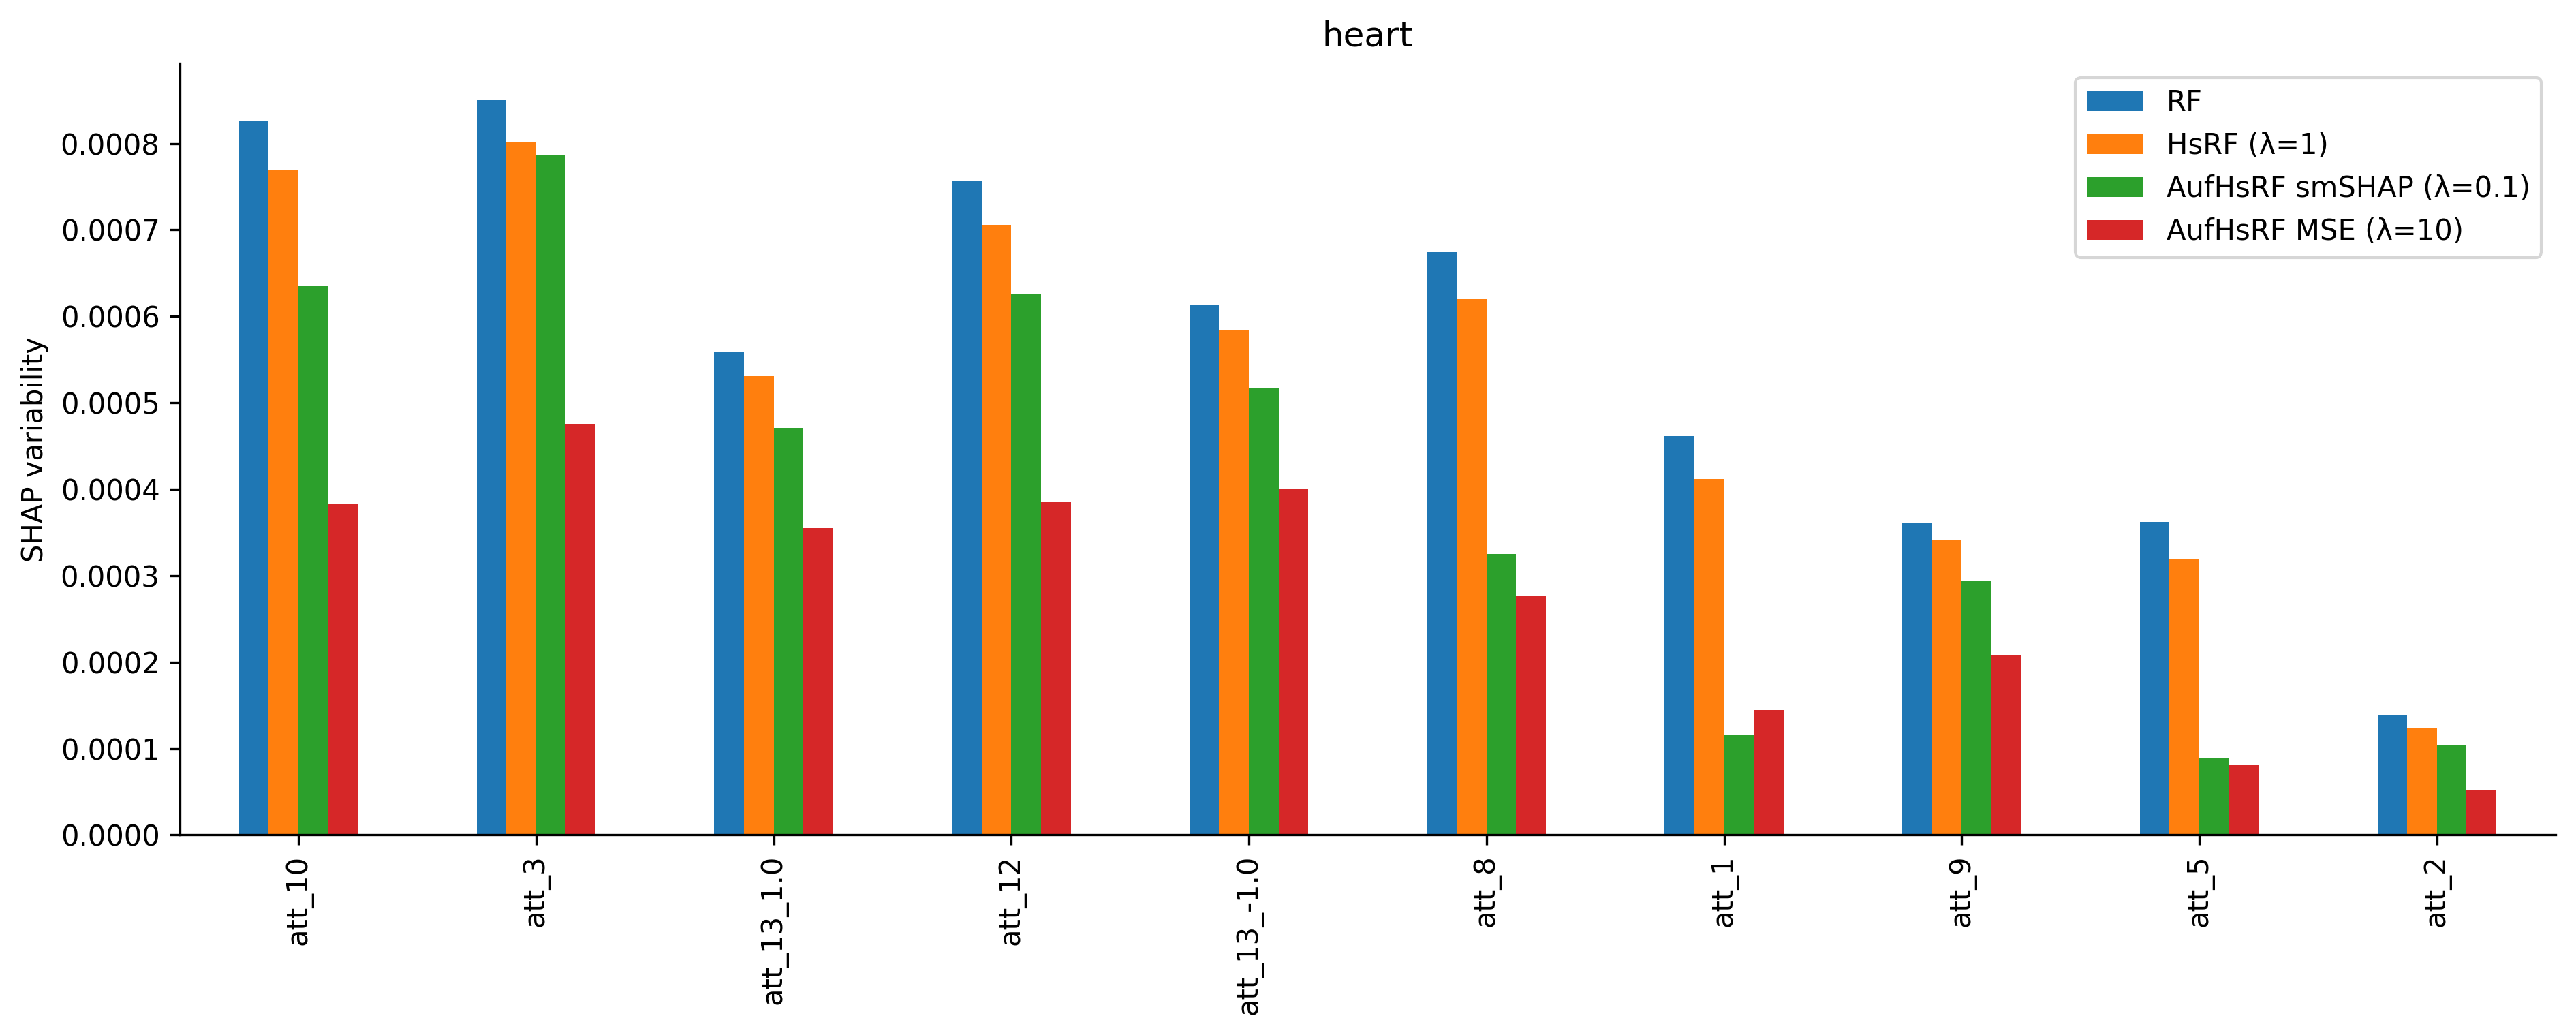

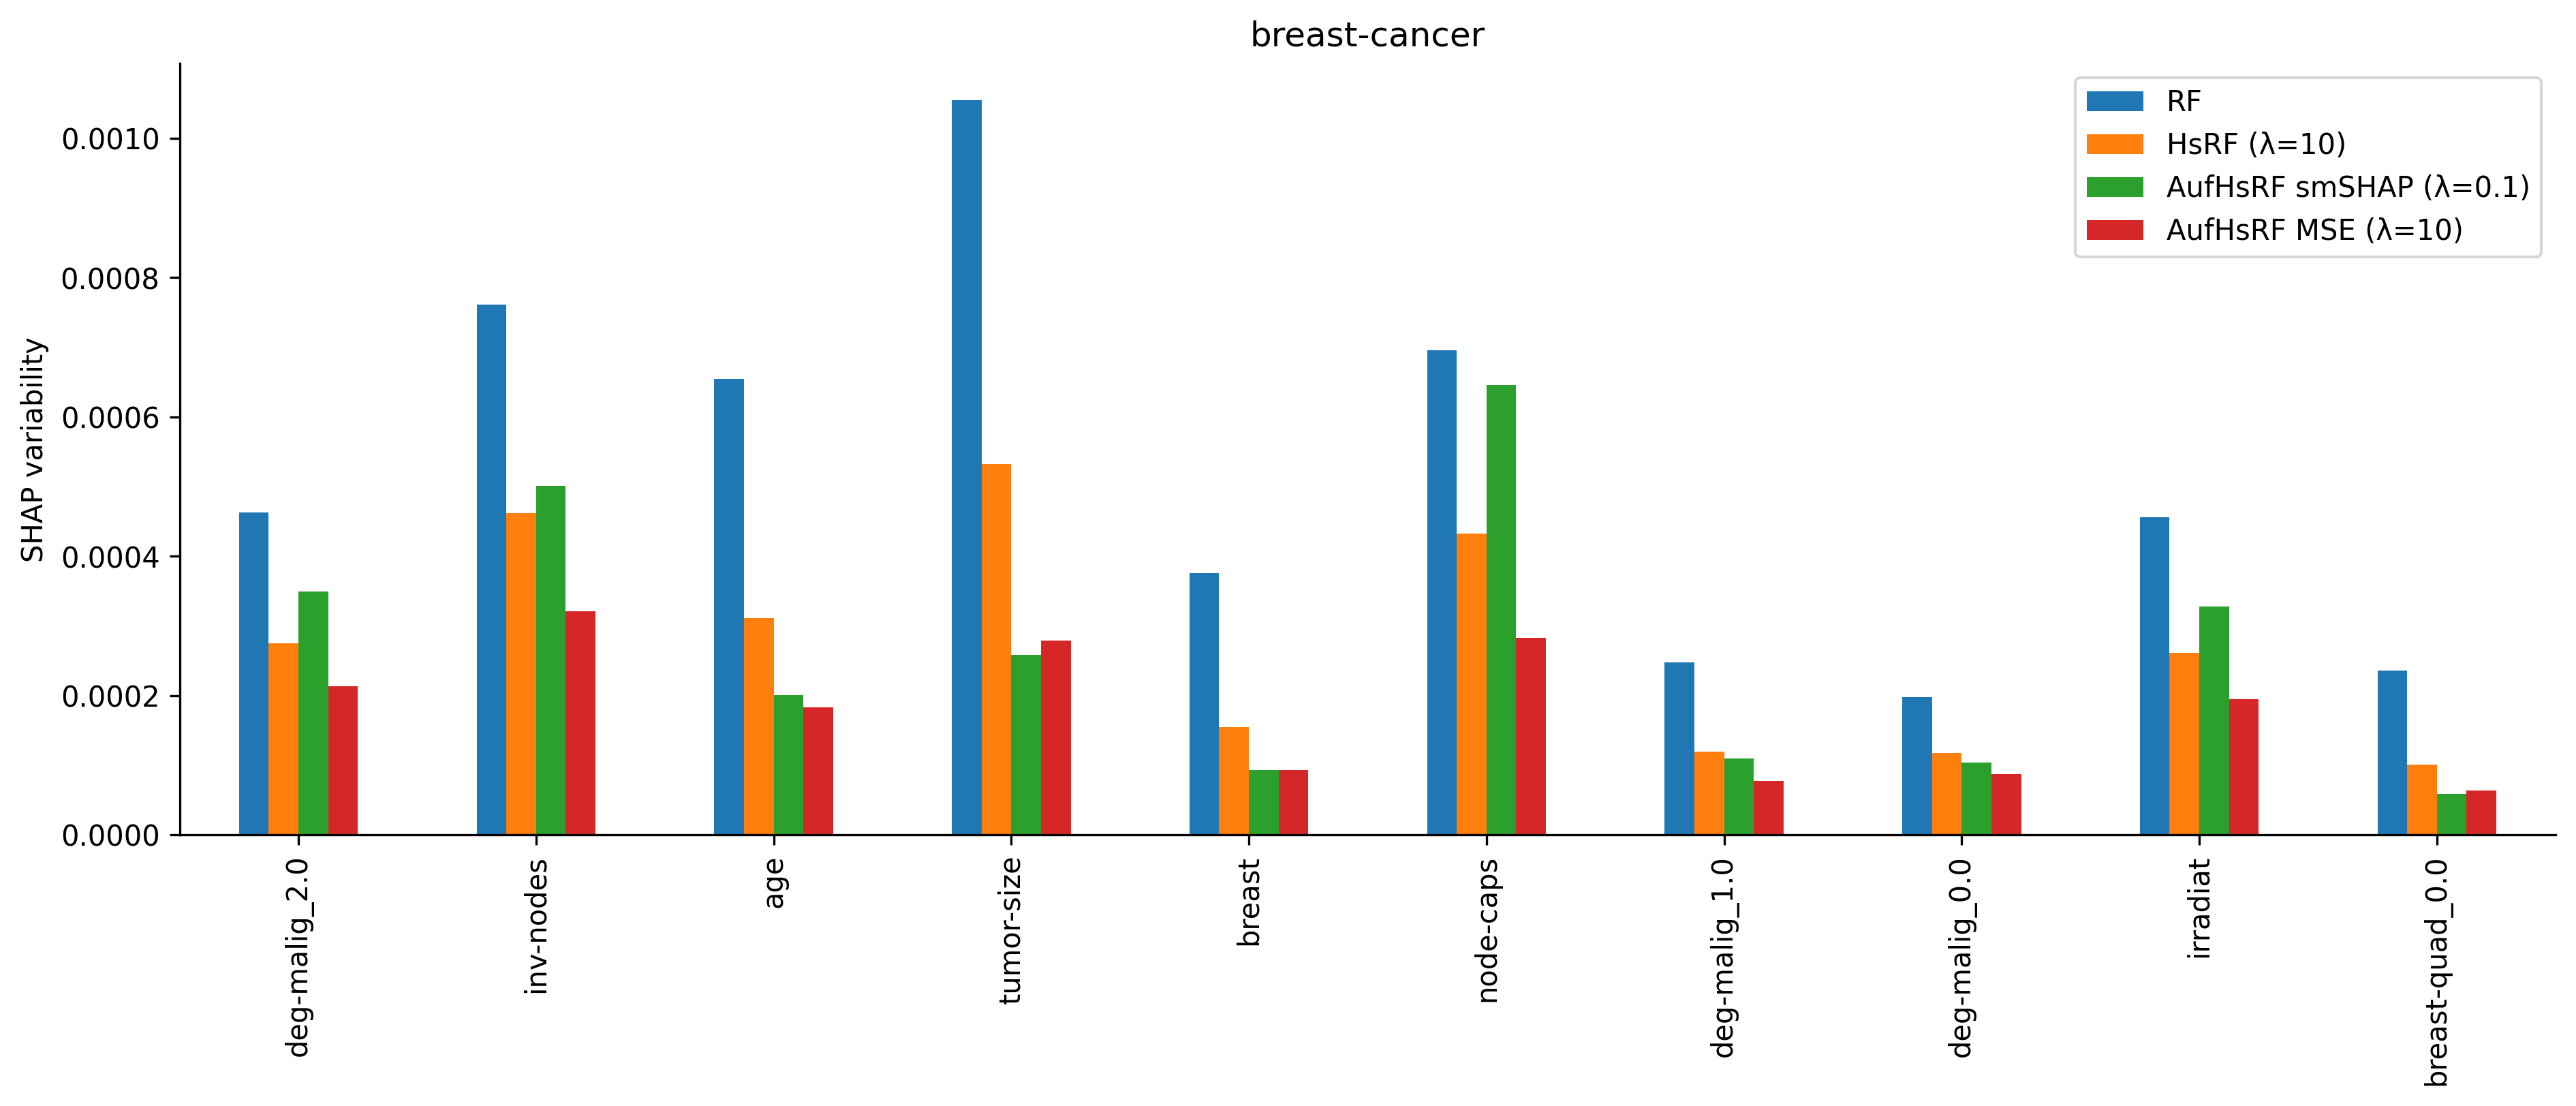

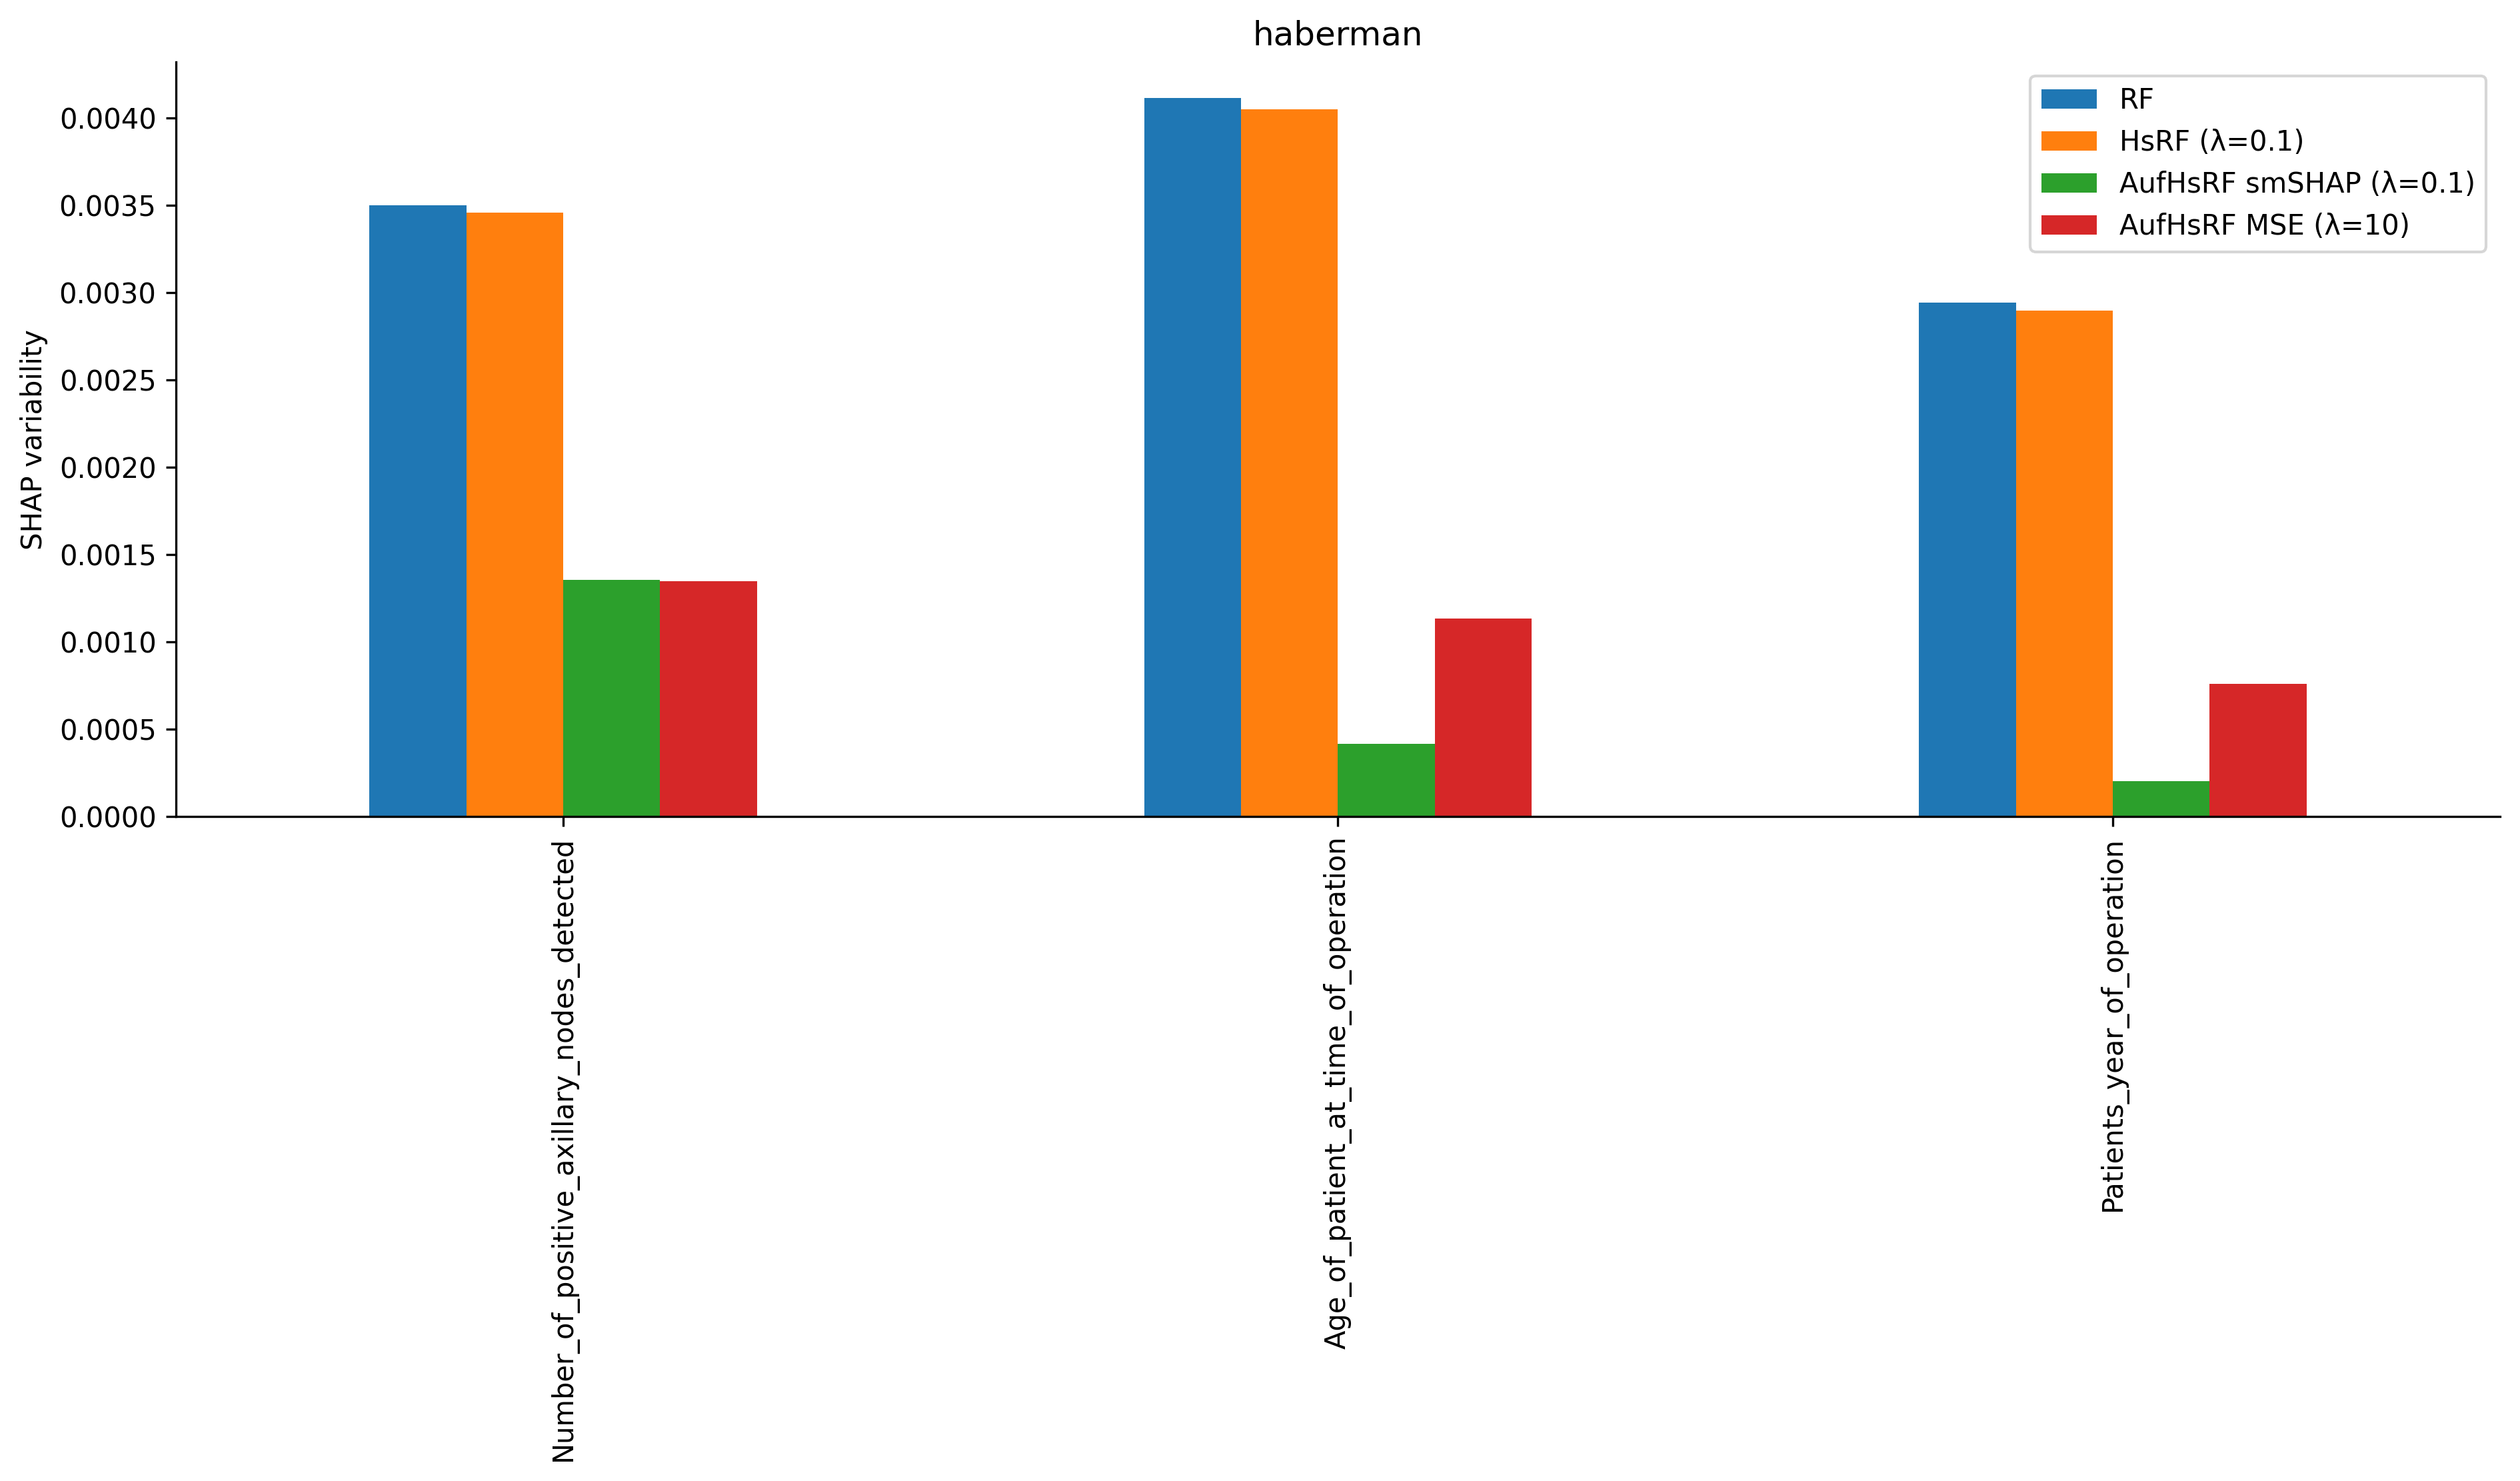

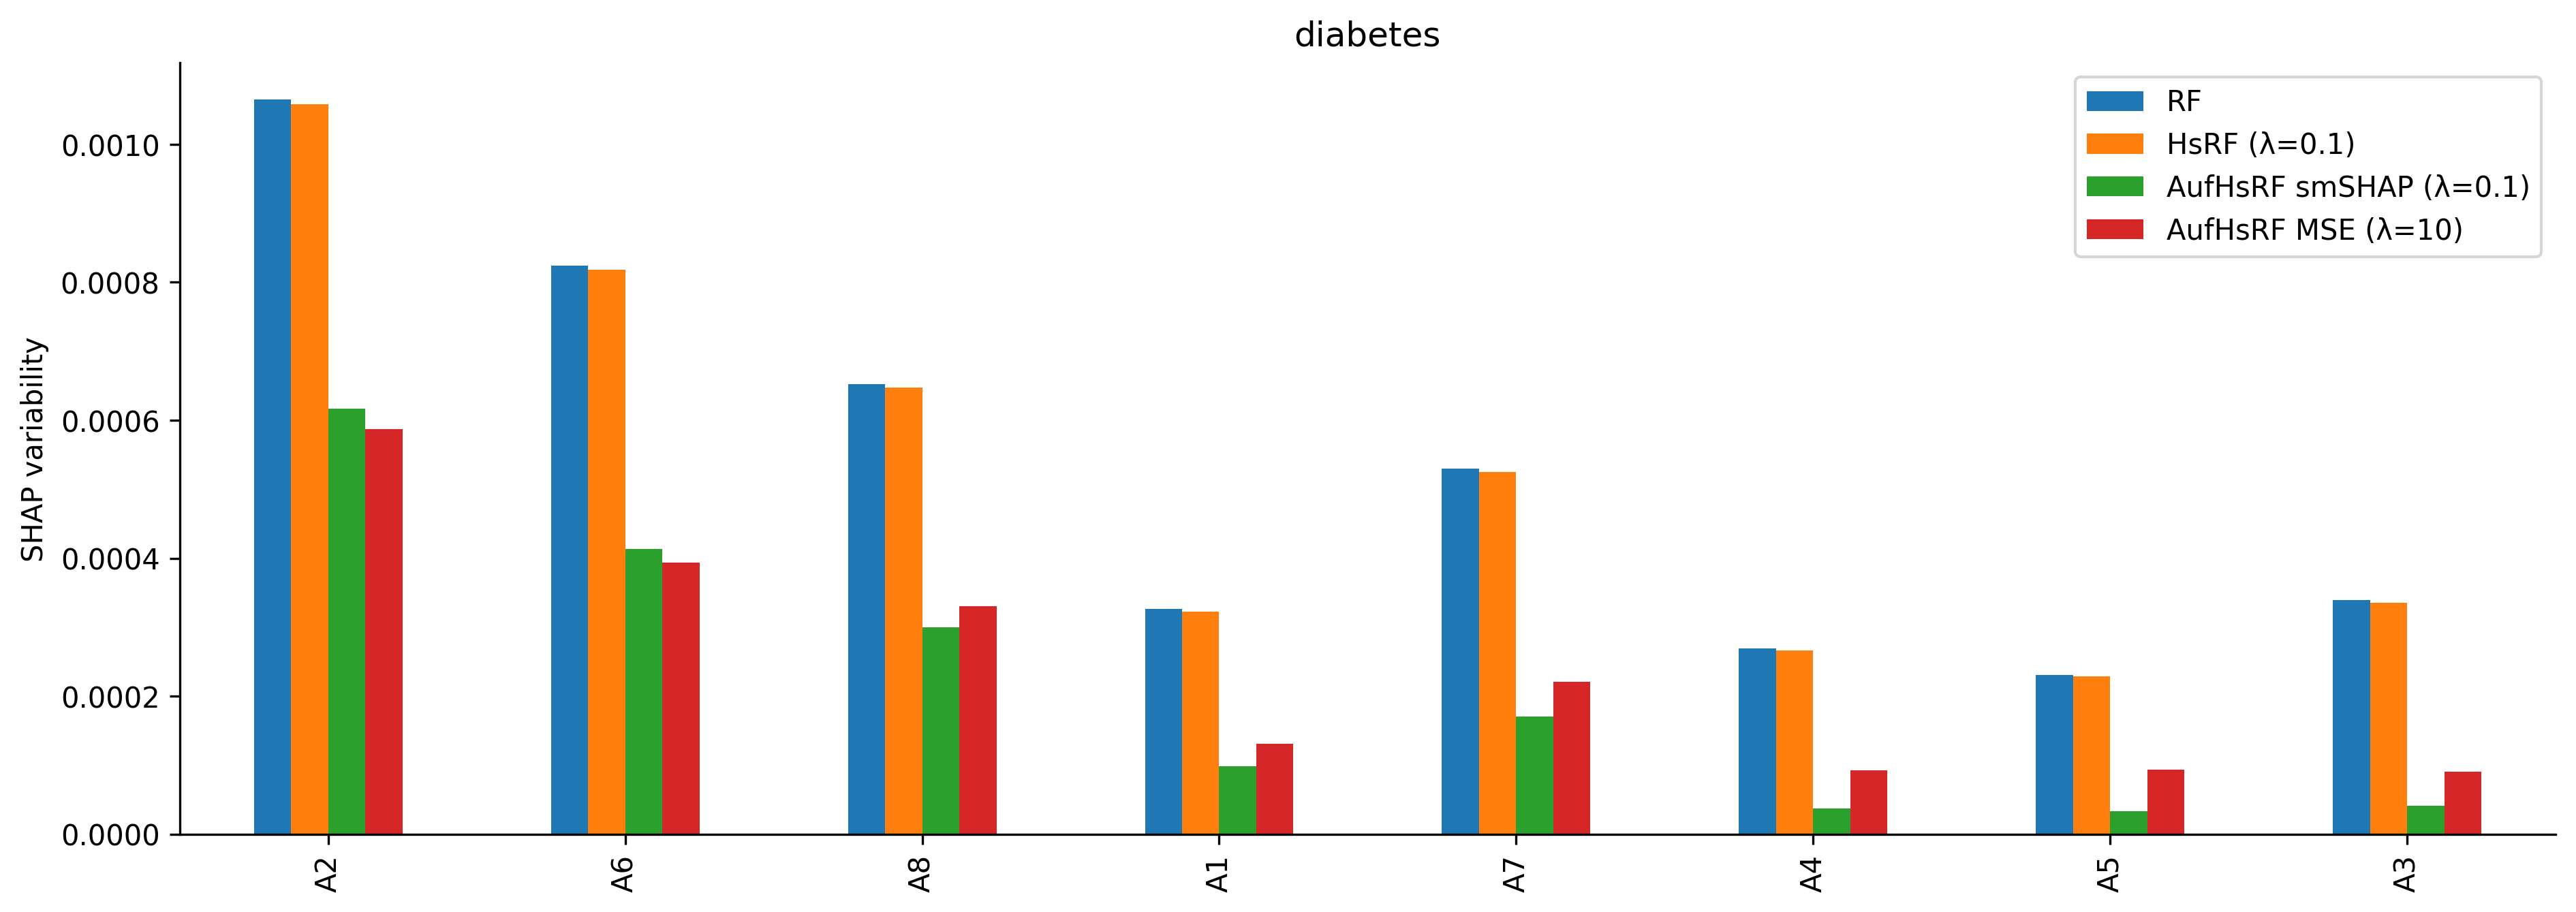

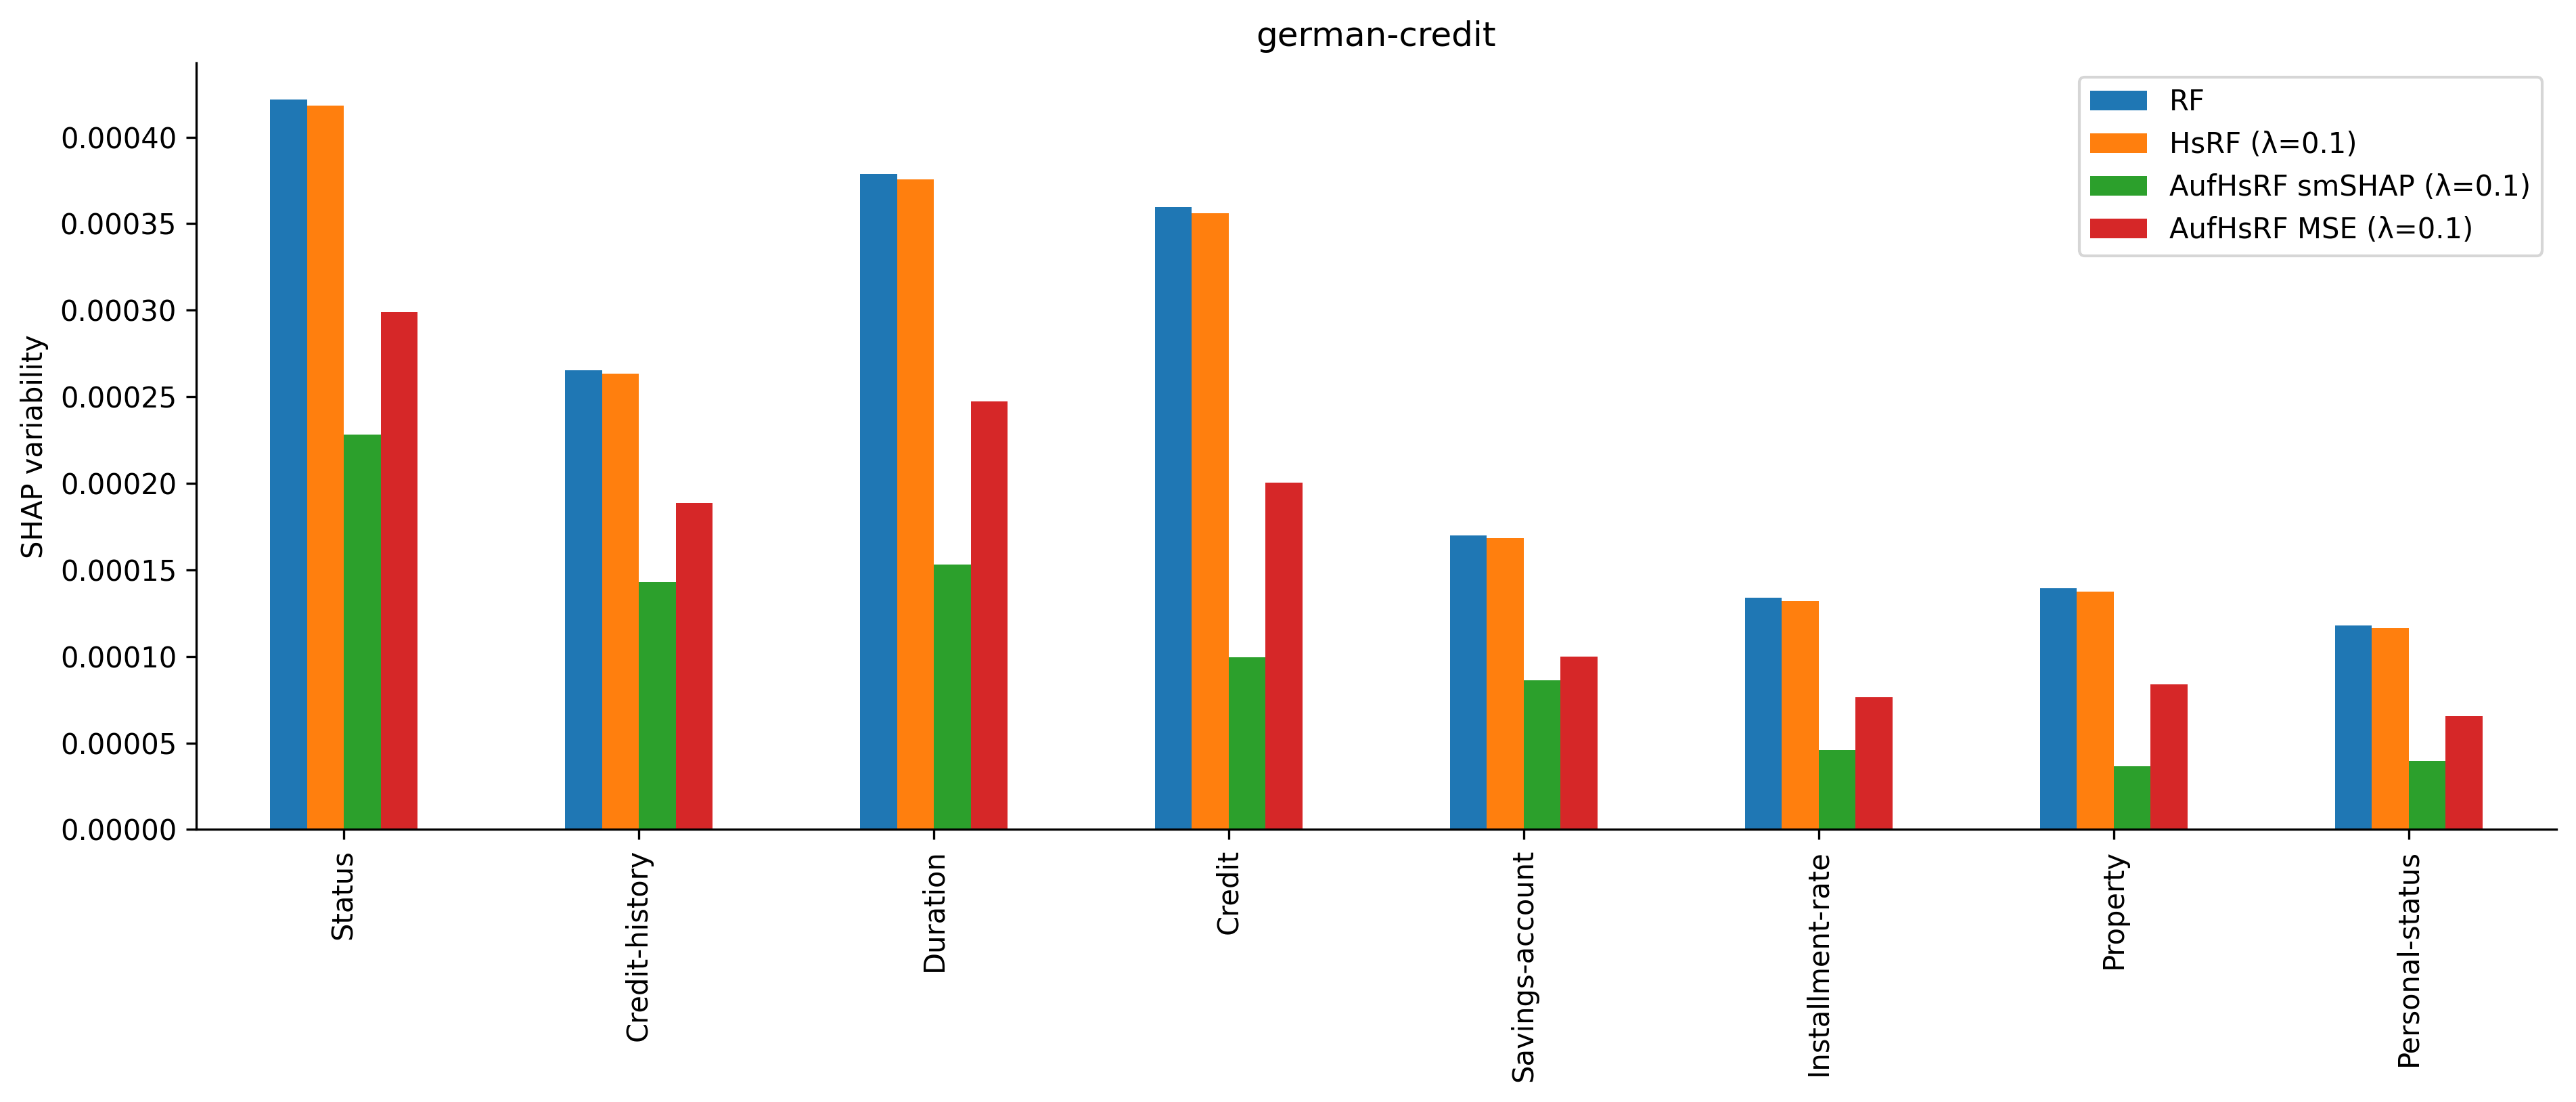

In [47]:
# Load pickle and create single plots
clf_names = ["heart","breast-cancer","haberman","diabetes","german-credit"]
clf_plot_combined={}

for name in clf_names:
    
    with open(f'{data_path}/{name}_SHAP_var.pickle', "rb") as input_file:
        
        pkl = pickle.load(input_file)
        feat_names_plot = clf_feat_names_plot[name]
        create_shap_variability_plot1(results=pkl, feat_names_plot=feat_names_plot)

### HS Regression datasets

Due to long computation time we exclude the abalone DS from this simulation

In [13]:
# # run experiment and create plot abalone
# reg_num = [3]
# for i in reg_num:
#     results = create_shap_stability_comparison(i, lambdas_dict=lambdas_reg, treetype="regression", n_estimators=50, n_iter=100, holdout_size=50, random_state=42)
#     create_shap_variability_plot1(results=results)

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
# # run experiment and create plot
# reg_num = [0,1,2,4]
# for i in reg_num:
#     results = create_shap_stability_comparison(i, lambdas_dict=lambdas_reg, treetype="regression", n_estimators=50, n_iter=100, holdout_size=50, random_state=42)
#     create_shap_variability_plot1(results=results)

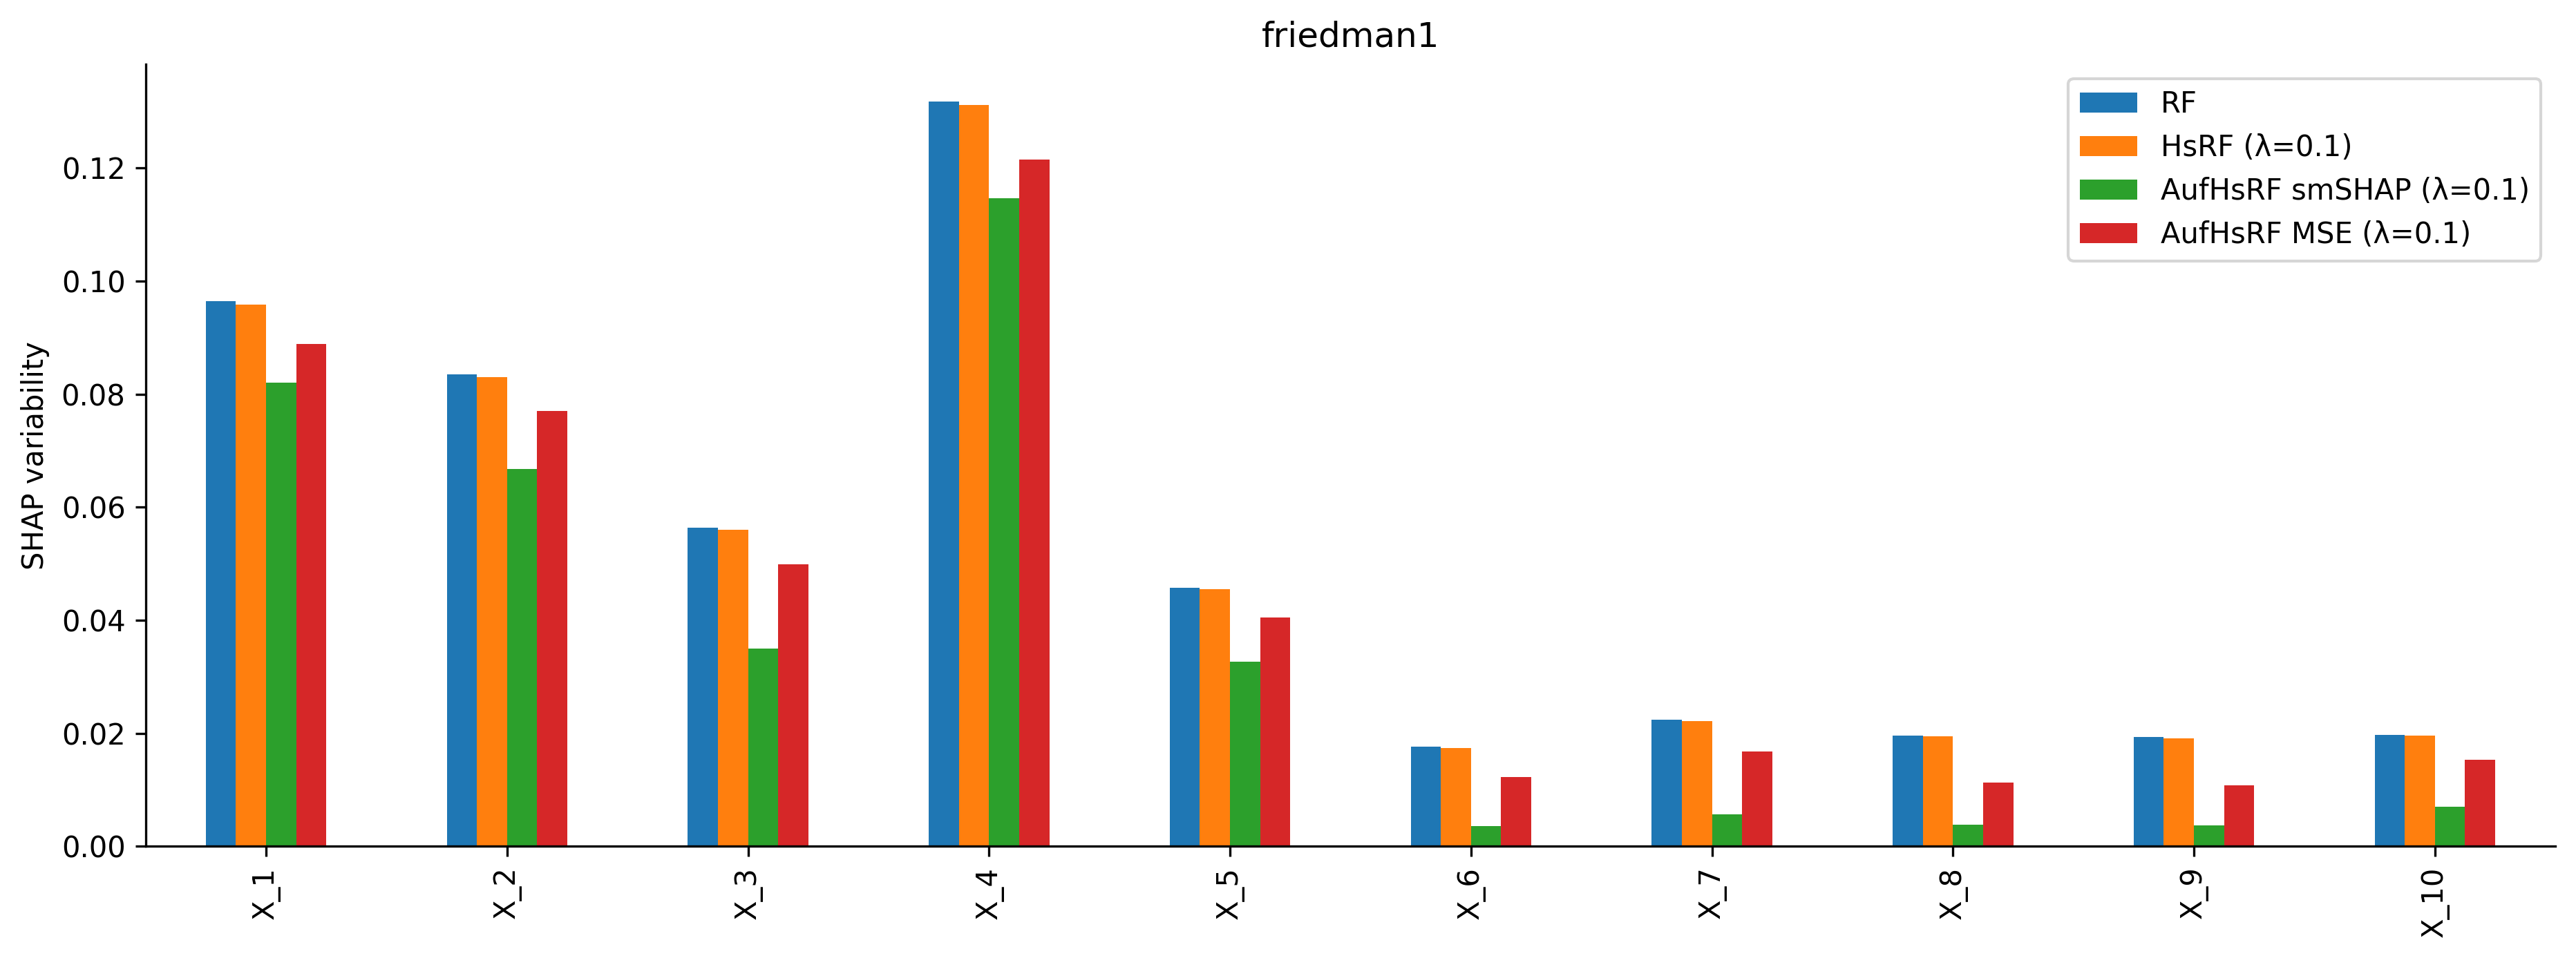

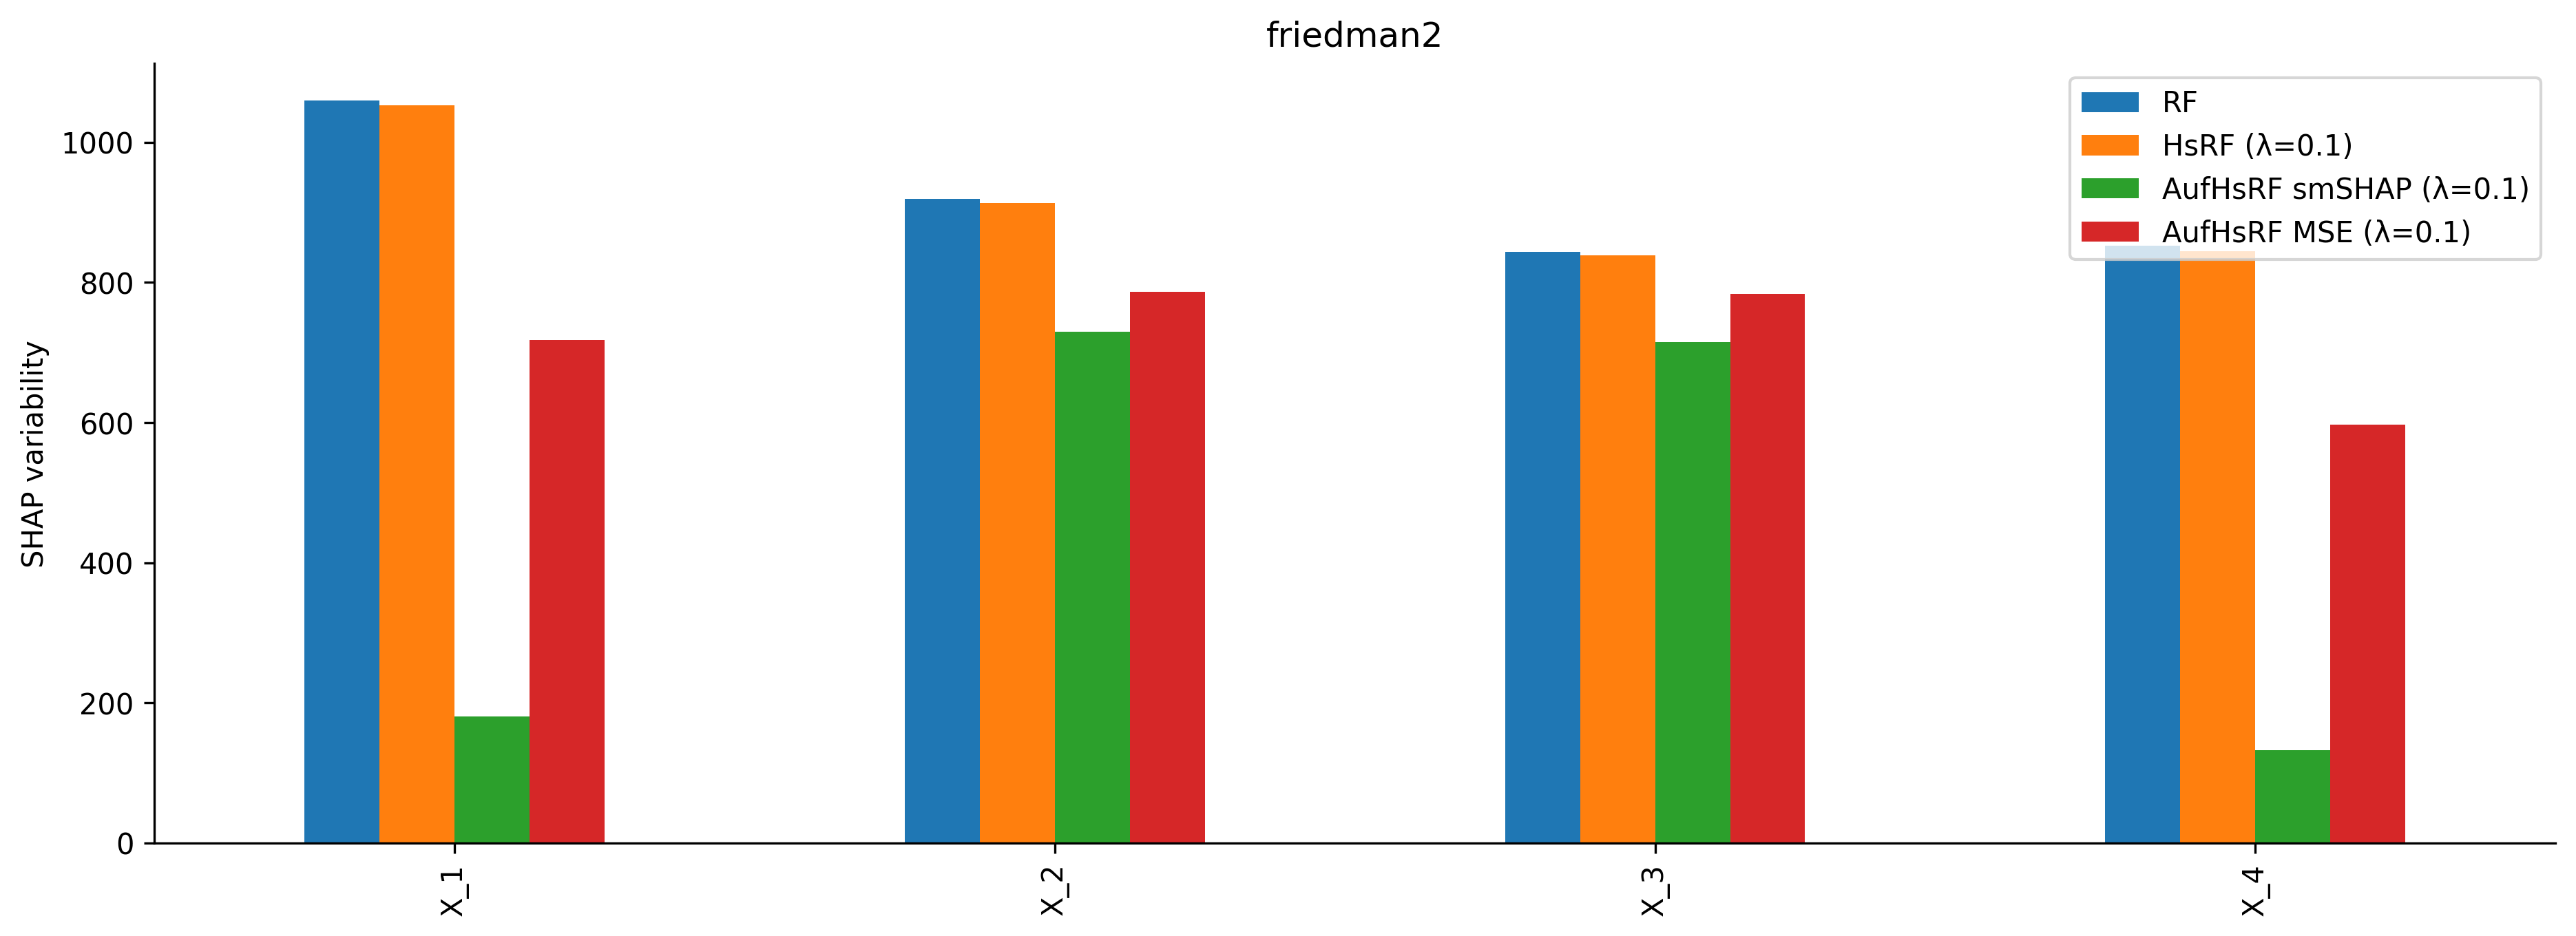

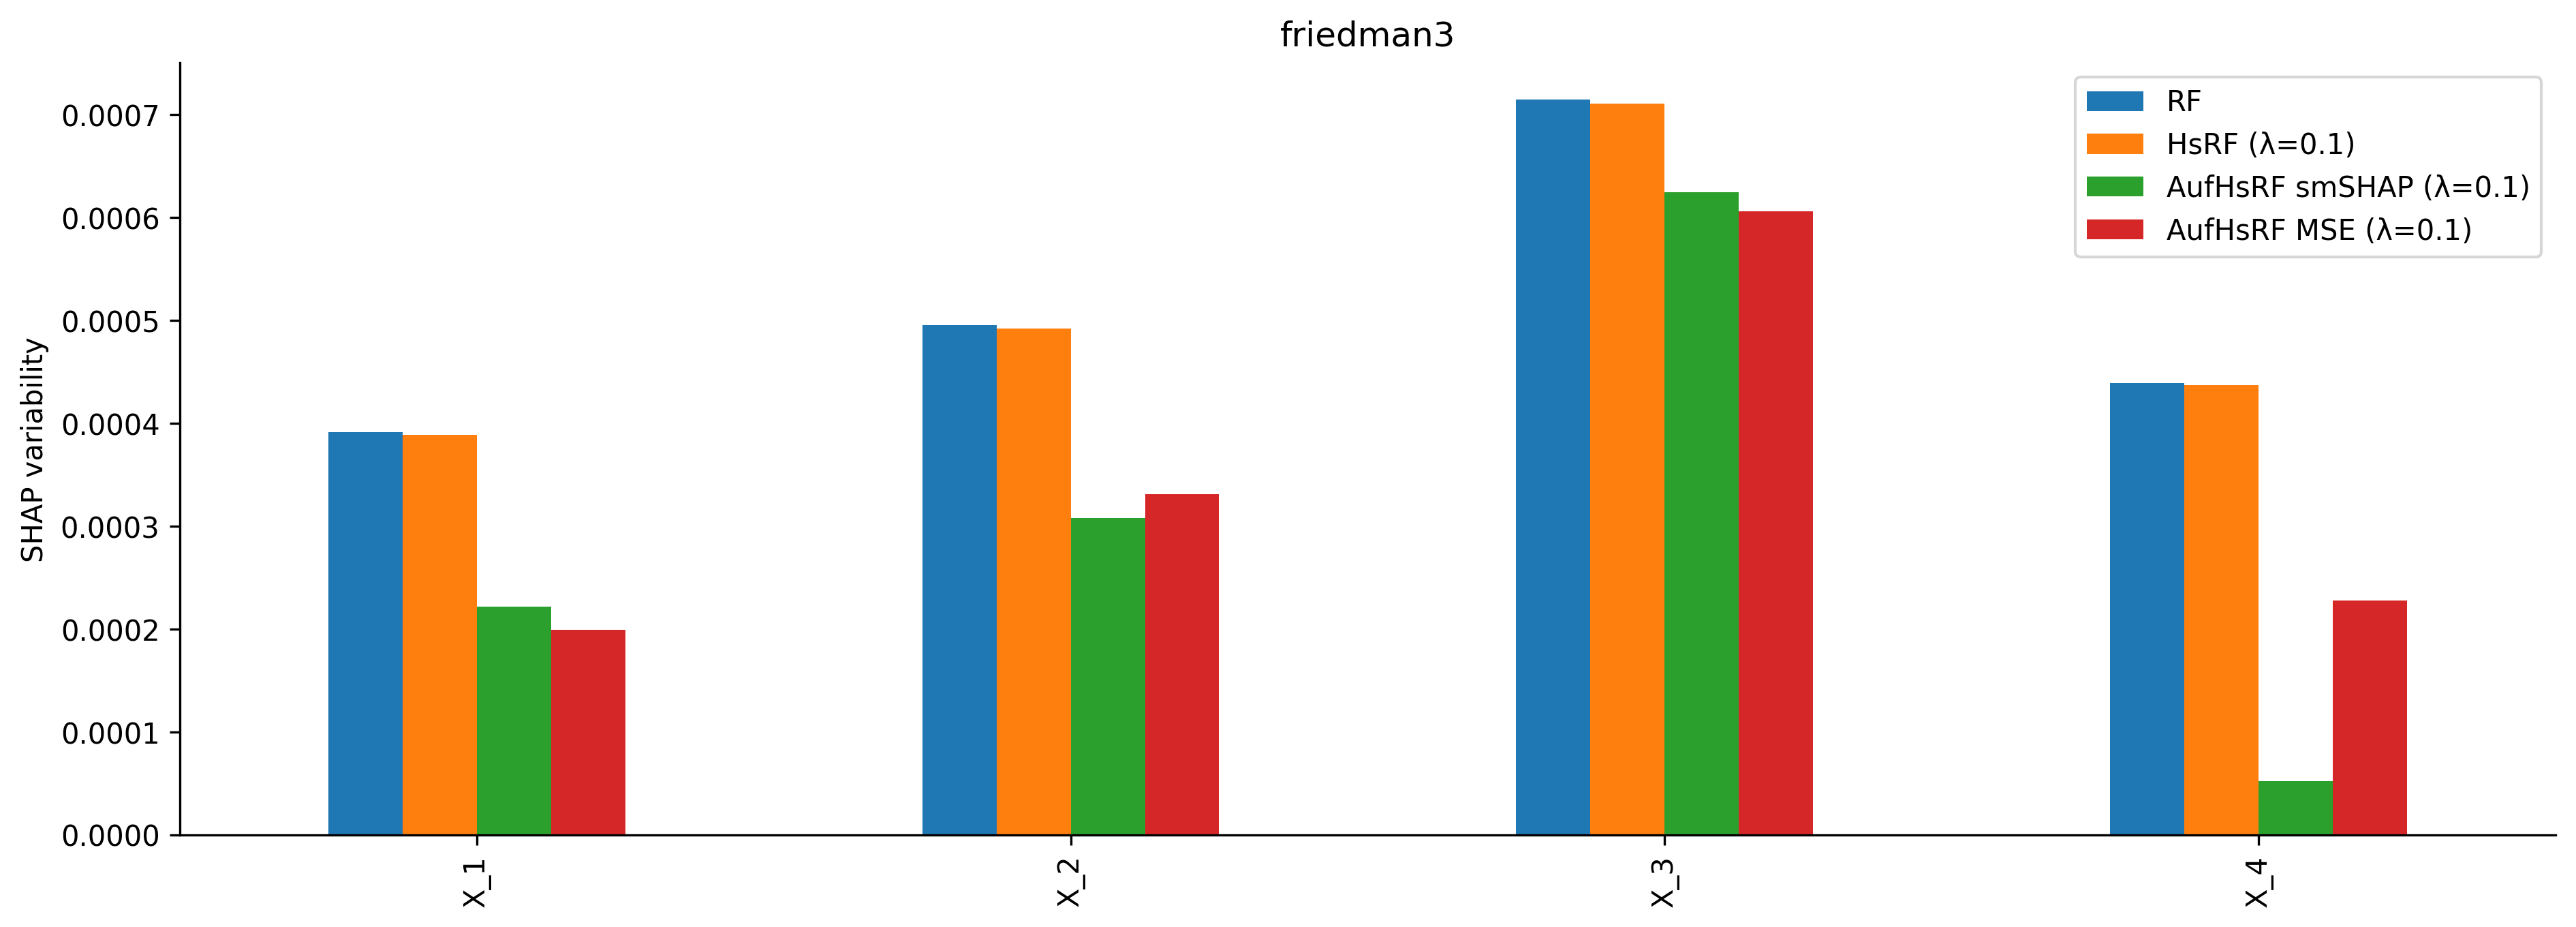

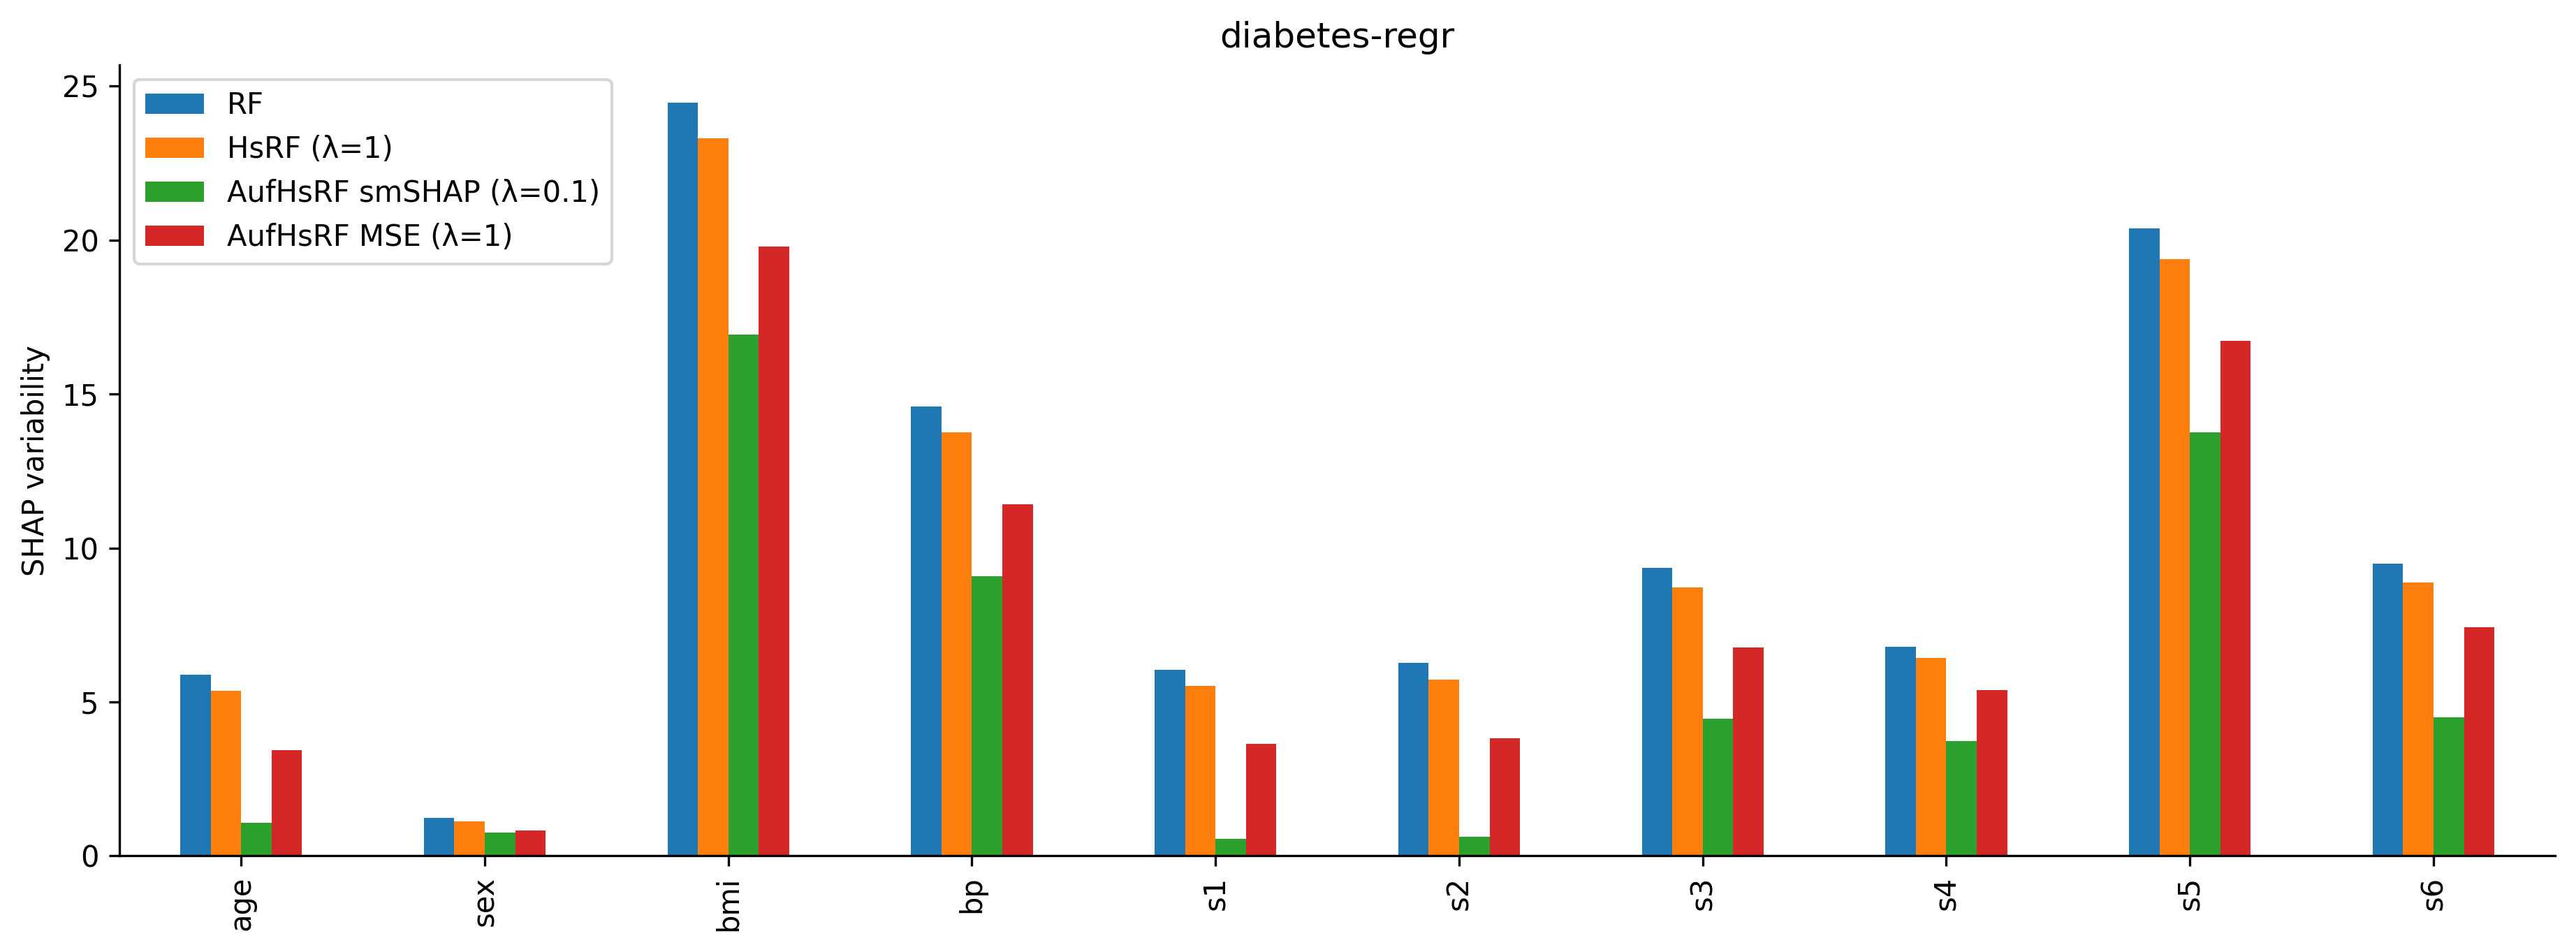

In [ ]:
# Load pickle and create single plots
reg_names = ["friedman1", "friedman2", "friedman3", "diabetes-regr"]

for name in reg_names:
    
    with open(f'{data_path}/{name}_SHAP_var.pickle', "rb") as input_file:
        
        pkl = pickle.load(input_file)
        create_shap_variability_plot1(results=pkl)

## Create combined plot for thesis document

In [6]:
# Create plot for all datasets
def create_shap_variability_plot_all(results, figsize=(20,15)):
    dfs = []
    model_names_plot = ["RF", "HsRF", "AufHsRF smSHAP", "AufHsRF MSE"]
    dset_names = list(results.keys())
    
    nrows = int(np.ceil((len(dset_names)/2)))
    fig, axs2d = plt.subplots(nrows, 2, figsize=figsize, squeeze=True)
    axs = axs2d.flatten()

    for dset in dset_names:
        
        shap_vals=results[dset]["shap_vals"]
        #feat_names=results[dset]["feat_names"]
        feat_order=results[dset]["feat_order"]
        feat_names_plot=results[dset]["feat_names_plot"]
        lambdas_dict = results[dset]["lambdas_dict"][dset]
        model_names = ["RF", "HsRF", "AufHsRF smSHAP", "AufHsRF MSE"]
        column_names = [f"{model} (λ={list(lambdas_dict.values())[i-1]})" if i!=0 else "RF" for i, model in enumerate(model_names)]
        
        # Create datafframe to create grouped bar plot
        df = pd.DataFrame([shap_vals.var(axis=0).mean(axis=0)[i] for i in feat_order], columns=column_names)
        df["feature"]=feat_names_plot
        dfs.append(df)

    for idx in range(len(dset_names)):
        

        ax = dfs[idx].plot(x='feature',
                kind='bar',
                stacked=False,
                title=dset_names[idx],
                legend=True,
                ax=axs[idx])
        ax.xaxis.label.set_visible(False)
        if idx%2==0:
            ax.set_ylabel("SHAP variability")



    if len(dset_names)%2!=0:
        axs[-1].set_visible(False)
        
    plt.tight_layout()

    return fig

### 2 sample datasets

In [8]:
# Load pickeled results
names = ["breast-cancer", "friedman1"]
plot_combined={}

for name in names:
    
    with open(f'{data_path}/{name}_SHAP_var.pickle', "rb") as input_file:
        
        pkl = pickle.load(input_file)
        
        shap_vals = pkl["SHAP_vals"]
        feat_names = pkl["data"]["feat_names"]
        lambdas_dict = pkl["simulation_settings"]["lambdas_dict"]
        if name=="breast-cancer":
            feat_order = [feat_names.index(feat) for feat in clf_feat_names_plot[name]]
            feat_names_plot = clf_feat_names_plot[name]
        else:
            feat_order = range(len(feat_names))
            feat_names_plot = feat_names
        
        plot_combined[name] = {"shap_vals":shap_vals, 
        "feat_names":feat_names, 
        "feat_order":feat_order, 
        "feat_names_plot":feat_names_plot, 
        "lambdas_dict":lambdas_dict}
        

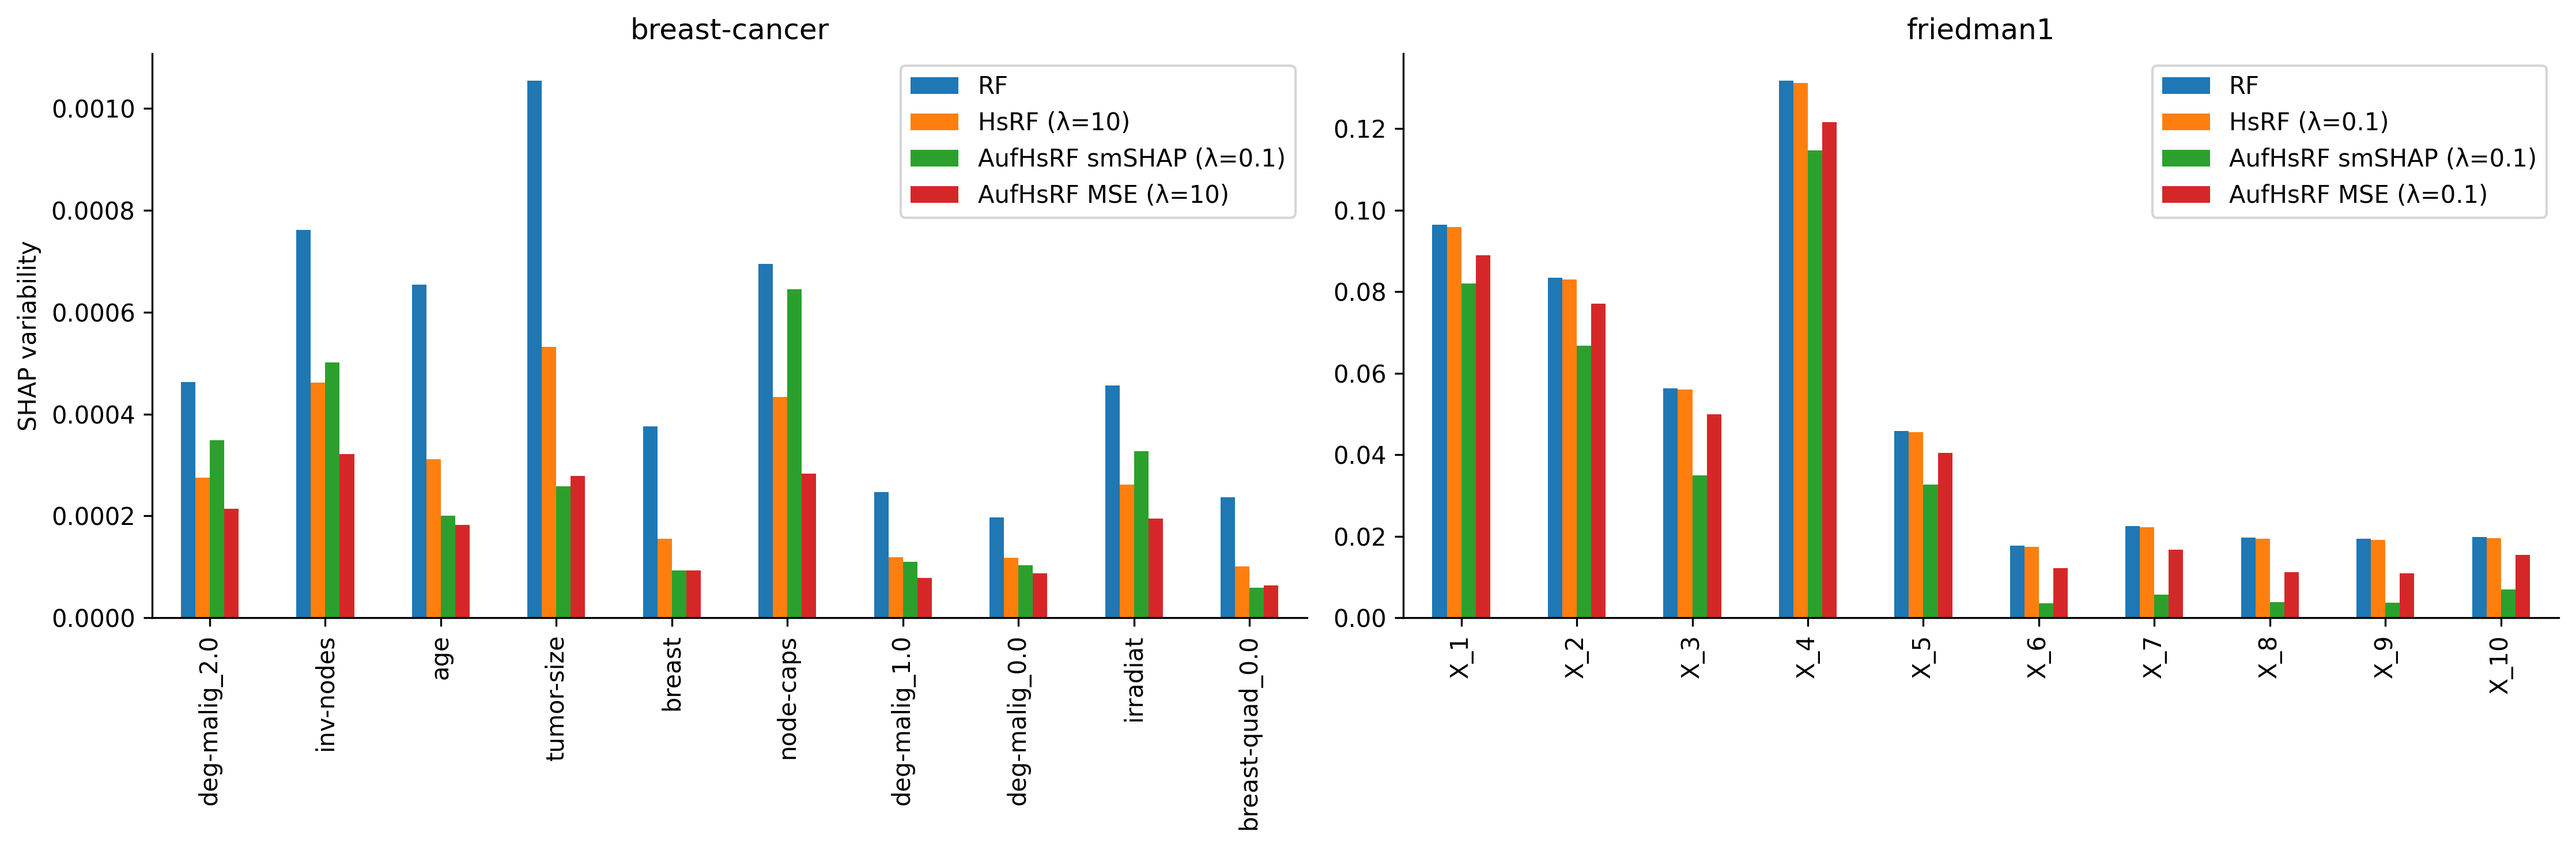

In [10]:
fig = create_shap_variability_plot_all(plot_combined, (15,5))

In [11]:
# Save figure
fig.savefig(f"{data_path}/2sample_combined_plot.png")  

### Classification datasets

In [9]:
# Load pickeled results
clf_names = ["heart","breast-cancer","diabetes","german-credit", "haberman"]
clf_plot_combined={}

for name in clf_names:
    
    with open(f'{data_path}/{name}_SHAP_var.pickle', "rb") as input_file:
        
        pkl = pickle.load(input_file)
        
        shap_vals = pkl["SHAP_vals"]
        feat_names = pkl["data"]["feat_names"]
        lambdas_dict = pkl["simulation_settings"]["lambdas_dict"]
        feat_order = [feat_names.index(feat) for feat in clf_feat_names_plot[name]]
        
        clf_plot_combined[name] = {"shap_vals":shap_vals, 
                                   "feat_names":feat_names, 
                                   "feat_order":feat_order, 
                                   "feat_names_plot":clf_feat_names_plot[name], 
                                   "lambdas_dict":lambdas_dict}
        

In [11]:
clf_plot_combined["haberman"]["feat_names_plot"] = ['# positive axillary\n nodes detected', 'Age at time\n of operation', 'Patients year\n of operation']

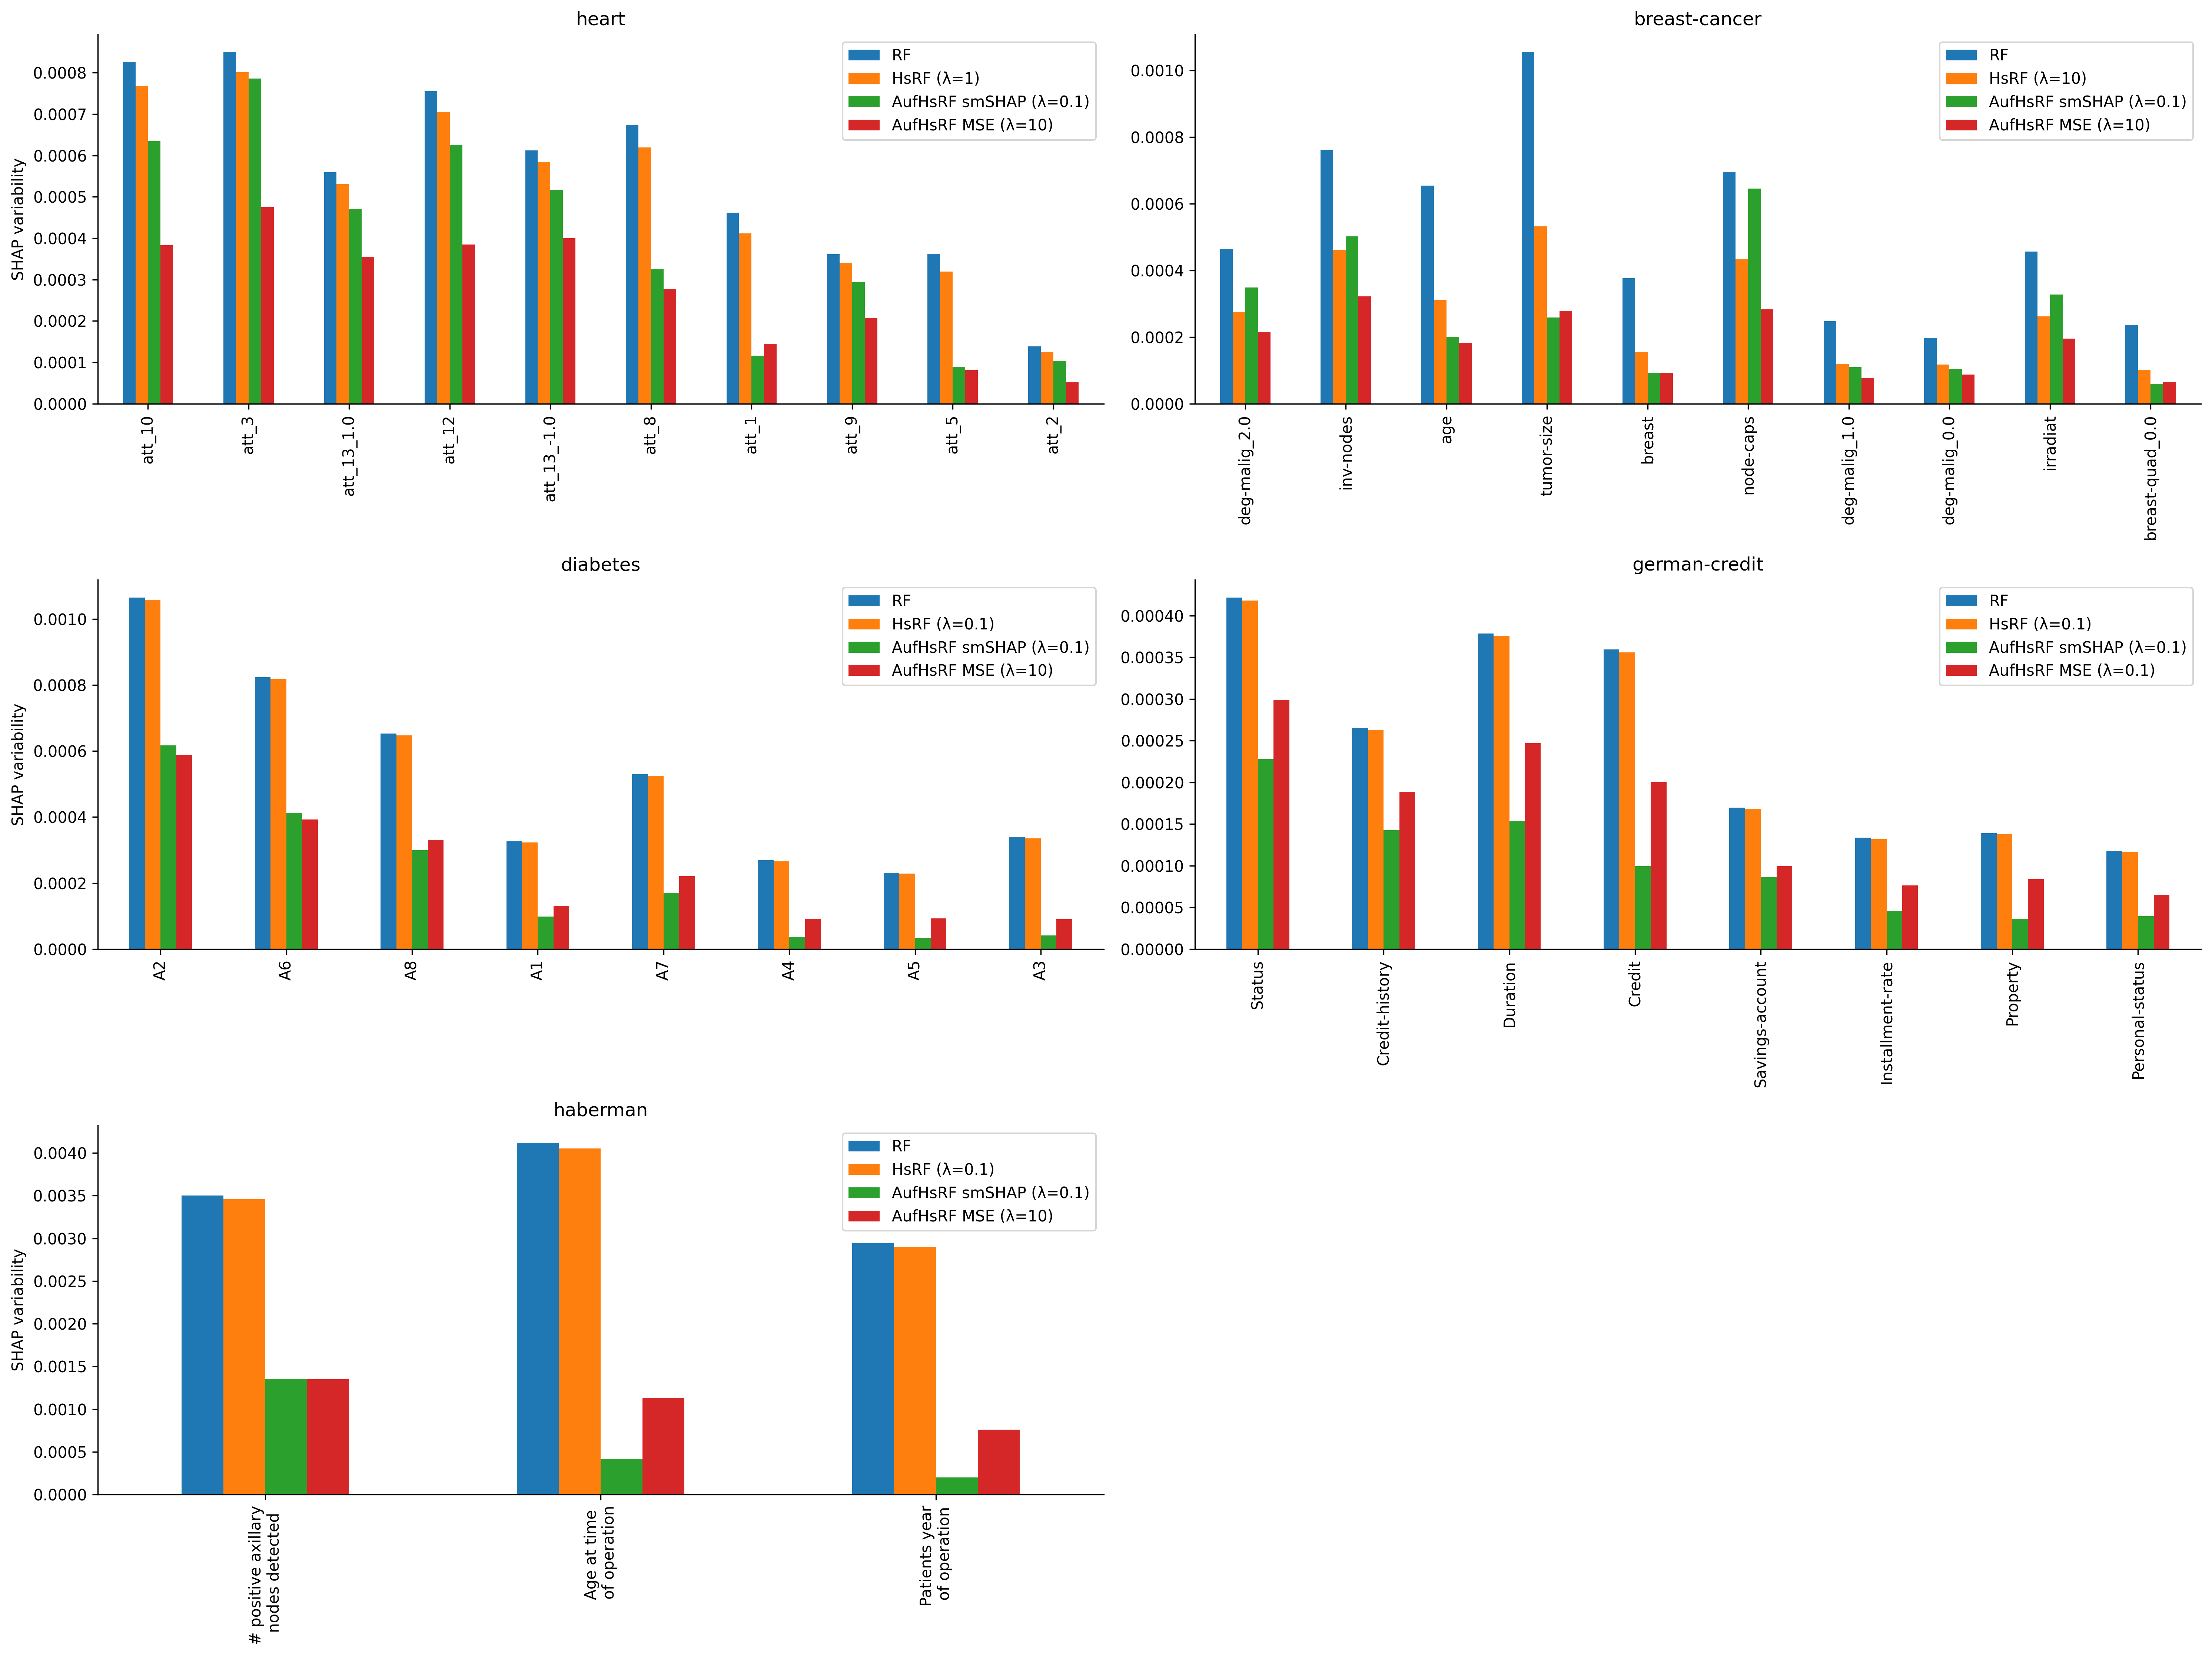

In [12]:
fig = create_shap_variability_plot_all(clf_plot_combined)

In [13]:
# Save figure
fig.savefig(f"{data_path}/clf_combined_plot.png")  

### Regression datasets

In [14]:
# Load pickeled results
reg_names = ["friedman1", "friedman2", "friedman3", "diabetes-regr"]
reg_plot_combined={}

for name in reg_names:
    
    with open(f'{data_path}/{name}_SHAP_var.pickle', "rb") as input_file:
        
        pkl = pickle.load(input_file)
        
        shap_vals = pkl["SHAP_vals"]
        feat_names = pkl["data"]["feat_names"]
        lambdas_dict = pkl["simulation_settings"]["lambdas_dict"]
        feat_order = range(len(feat_names))
        
        reg_plot_combined[name] = {"shap_vals":shap_vals, "feat_names":feat_names, "feat_order":feat_order, "feat_names_plot":feat_names, "lambdas_dict":lambdas_dict}

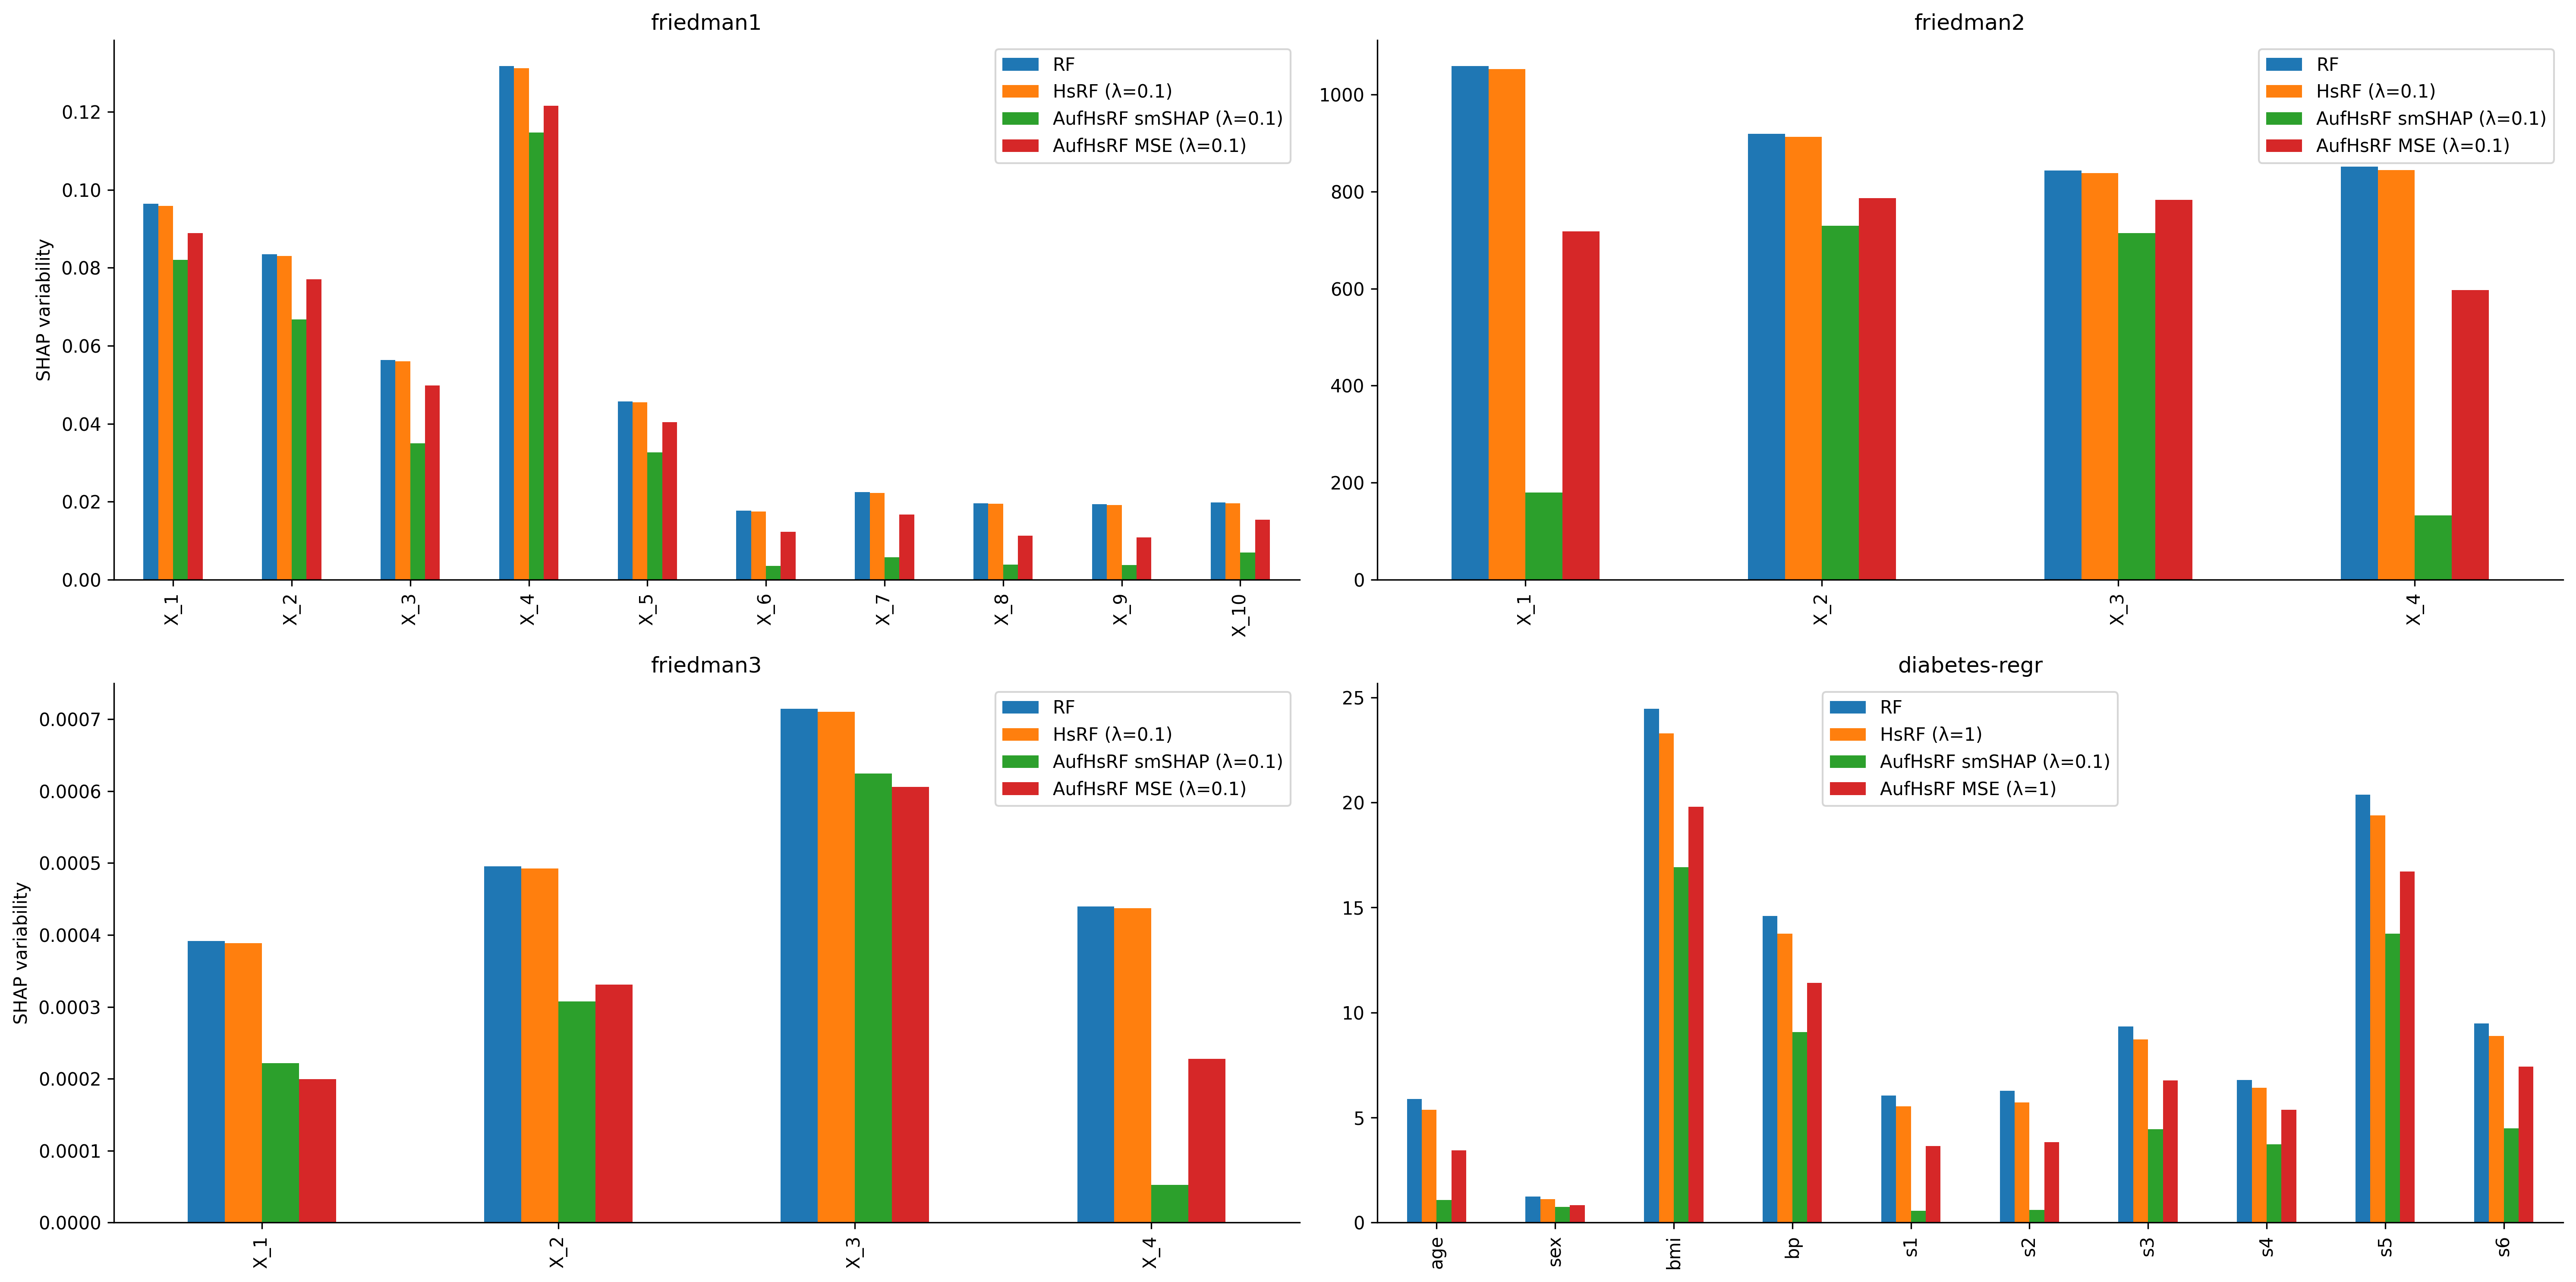

In [15]:
fig = create_shap_variability_plot_all(reg_plot_combined, figsize=(20,10))

In [16]:
# Save figure
fig.savefig(f"{data_path}/reg_combined_plot.png")  